# Aprendizaje Automático - Práctica 3 - Ajuste de Modelos Lineales

# Problema de Regresión

#### Valoración máxima: 6 puntos

#### Fecha límite de entrega: 4 de Junio de 2023 a las 23:59

#### Entrega a través de https://pradogrado2223.ugr.es/

### Nombre completo: <mark>YERAY LÓPEZ RAMÍREZ</mark>



---

In [ ]:
import numpy as np # Vectores
import pandas as pd # Dataframes
from matplotlib import pyplot as plt # Gráficas
import seaborn as sns # Gráficas más completas
from IPython.display import display, Latex, Markdown # Tablas

# Funciones SKLEARN

# Modelos
from sklearn.linear_model import LinearRegression # Linear Regression

from sklearn.model_selection import train_test_split # División de datos
from sklearn.decomposition import PCA #  Técnica de reducción de dimensionalidad PCA

# Normalización
from sklearn.preprocessing import StandardScaler # Media 0 y desviación estándar 1
from sklearn.preprocessing import PolynomialFeatures # Para la generación de características polinomiales

# Medidas
from sklearn.metrics import mean_squared_error # Error Cuadrático Medio
from sklearn.metrics import mean_absolute_error # Error Absoluto Medio
from sklearn.metrics import median_absolute_error # Error Absoluto Mediano
from sklearn.metrics import r2_score # Coeficiente de Determinación R2
from sklearn.model_selection import learning_curve # Curva de Aprendizaje

# Regularización
from sklearn.linear_model import Ridge # Regularizacion L2
from sklearn.linear_model import Lasso # Regularizacion L1

# Regularización con Cross Validation
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

# Otras funciones
from sklearn.compose import TransformedTargetRegressor  # Regresor con transformación objetivo
from sklearn.metrics import PredictionErrorDisplay  # Visualización de errores de predicción
from sklearn.preprocessing import QuantileTransformer  # Transformación cuantílica

# Fijar semilla
np.random.seed(1)

**Normas de desarrollo y entrega de trabajos**

- Única y exclusivamente se debe entregar este Notebook de Colab (fichero .ipynb). No es necesario entregar ninguna memoria externa, pero el código debe estar bien comentado, y todas las decisiones tomadas y el trabajo desarrollado deben documentarse suficientemente en celdas de texto.

- La entrega en PRADO está configurada para permitir sucesivas entregas de la práctica. Desde este punto de vista, se recomienda subir versiones de la práctica a medida que se van realizando los distintos ejercicios propuestos, y no dejarlo todo para el final, dado que es altamente improbable que se extienda la fecha de entrega.

- Reiterar que es obligatorio documentar las valoraciones y decisiones adoptadas en el desarrollo de cada uno de los apartados. Debe incluirse también una valoración razonada sobre la calidad de los
resultados obtenidos. Sin esta documentación, se considera que el trabajo NO ha sido presentado.

- Se debe respetar la estructura y secciones del Notebook. Esto servirá para agilizar las correcciones, así como para identificar con facilidad qué ejercicio/apartado se está respondiendo.

- El codigo NO puede escribir nada a disco.

- Se espera que el código siempre lea de un directorio llamado 'drive/MyDrive/Colab Notebooks/datos/', situado dentro del directorio donde se desarrolla y ejecuta la práctica. No se admiten excepciones a esta ruta de acceso a los datos.

- Una entrega es apta para ser corregida si se puede ejecutar de principio a fin sin errores.

- No es válido usar opciones en las entradas (es decir, utilizar el comando `input`, por ejemplo, para que el usuario escoja el valor de las variables para ejecutar el programa). Para ello, se deben fijar al comienzo los valores
por defecto que se consideren óptimos o que se soliciten en el enunciado.

- El código debe estar obligatoriamente comentado explicando lo que realizan los distintos apartados y/o bloques.

- Se entrega solamente este Notebook, y no los datos empleados.


---

<font color='blue'>Este trabajo  se centra en el ajuste y selección del mejor predictor lineal para un conjunto de datos dado. Para ello, se recomienda el uso de la librería Scikit-Learn (https://scikit-learn.org/). Esta librería contiene funciones de alto nivel que pueden ser muy útiles para el desarrollo de la práctica. En cualquier caso, para cada función de Scikit-Learn que se use, debe explicar por qué es necesario su uso, así como explicar su funcionamiento y el significado de todos sus parámetros. En relación con este punto, los valores por defecto en la librería no se consideran elecciones justificadas $\textit{a priori}$ y, al igual que en el resto de la práctica, decisiones sin justificación y resultados sin interpretación no serán considerados válidos.



In [ ]:
#Para acceder a nuestros ficheros de Google Drive
from google.colab import drive
drive.mount('/content/drive')
# La carpeta datos (que contiene OnlineNewsPopularity.csv, OnlineNewsPopularity.names)
# debe estar en vuestro Drive, dentro de la carpeta 'Colab Notebooks'
ruta = 'drive/MyDrive/Colab Notebooks/datos/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Función auxiliar que permite la lectura de un fichero y lo estructura en un
# dataframe
def leer_datos(archivo, separador=";", header=None): # Por defecto el separador es ;
    # Los datos se guardan en un dataframe
    """
    IMPORTANTE. Al generar un dataframe con pandas usando
    la lectura de ficheros, la primera fila actuará como la cabecera del mismo
    Hay que indicarle que no hay cabecera si el fichero no la tiene.
    En este caso, el fichero de regresión contiene una primera fila como la cabecera
    """
    if header is None:
      datos = pd.read_csv(archivo, sep=separador, header=None, skipinitialspace=True)
    else:
      datos = pd.read_csv(archivo, sep=separador, skipinitialspace=True)

    return datos

In [ ]:
# Operaciones con dataframes

# Une vectores de datos y objetivo en un dataframe
def join_(X,Y, cols):
  joined_data = np.column_stack((X, Y))

  # Crear un DataFrame de train
  return pd.DataFrame(joined_data, columns=cols)

# Une dataframes de datos y objetivo
def rejoin_(X,Y):
  return pd.concat([X,Y], axis=1, join='inner')

# Obtiene componentes X o Y de un dataframe
def X_(X):
  return X.iloc[:, :-1]
def Y_(X):
  return X.iloc[:, -1]

In [ ]:
# Función que separa la muestra en sus características y objetivo
def separar_datos(data):
    valores = data.values

    # Todas las columnas excepto la última son los valores a usar (X)
    X = valores[:, 0:-1]

    # La última columna son los valores a predecir (Y)
    Y = valores[:, -1]

    return X, Y

In [ ]:
# Cuenta el número de veces que aparece un rango de articulos compartidos y hace un muestreo
# Servirá para ver qué tan balanceados están los datos
def show_histogram(data, titulo, xlabel, ylabel, intervalo, percentil):
    fig, ax = plt.subplots(figsize=(20,10))

    # Obtener los valores de la columna objetivo
    ctarget = data.iloc[:,-1].values.astype(int)

    # Definir los límites de los intervalos
    maximo = float(np.percentile(ctarget, percentil))
    intervalos = np.arange(min(ctarget)-1, maximo + intervalo, intervalo, dtype=float)

    # Agrupar los números en intervalos y contar las ocurrencias
    conteo = pd.cut(ctarget, bins=intervalos).value_counts()
    total = conteo.sum()  # Total de datos

    # Calcular el porcentaje de datos en cada barra
    porcentaje = conteo / total * 100

    # Crear el histograma utilizando seaborn
    sns.barplot(x=conteo.index, y=conteo.values)

    plt.xticks(rotation=90)  # Rotación de 90 grados para las etiquetas del eje x

    # Mostrar el porcentaje en cada barra del histograma
    for i, v in enumerate(porcentaje):
      ax.text(i, int(conteo.values[i]/2), f'{v:.2f}%', ha='center', va='bottom', rotation='vertical')

    # Etiquetas y título
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(titulo + '. Intervalos de ' + str(intervalo) + ' en ' + str(intervalo))

    # Mostrar el histograma
    plt.show()

In [ ]:
# Dibuja cajas de dispersión de cada característica
# Servirá para ver los datos atípicos
def boxplot_matrix(X, titulo):
    # Obtener las columnas numéricas
    num_cols = X.select_dtypes(['int64', 'float64']).columns
    num_cols_count = len(num_cols)

    # Calcular el número de filas y columnas para la disposición de los subplots
    rows = int(num_cols_count / 3) + (num_cols_count % 3 > 0)
    cols = 7

    # Crear la figura y los subplots
    fig, axes = plt.subplots(rows, cols, figsize=(15, 20))
    fig.suptitle(titulo)

    # Recorrer cada columna numérica y crear el boxplot correspondiente
    for i, col in enumerate(num_cols):
        ax = axes[i // cols, i % cols]  # Obtener el subplot correspondiente
        sns.boxplot(X[col], ax=ax)  # Crear el boxplot
        ax.set_title(col)  # Establecer el título del subplot
        ax.set_xlabel('')  # Eliminar etiqueta del eje x
        ax.set_ylabel('')  # Eliminar etiqueta del eje y

    # Eliminar subparcelas no utilizadas si hay menos de 3 columnas
    if num_cols_count % 3 != 0:
        for j in range(num_cols_count, rows * cols):
            fig.delaxes(axes[j // cols, j % cols])

    plt.tight_layout()
    plt.show()

In [ ]:
# Calculo de variables continuas
# display(regress_data.describe()) # muestra una tabla similar
def crear_tabla_valores(Train):
  media = Train.mean()   # Media
  mediana = Train.median()   # Mediana
  desviacion_tipica = Train.std()   # Desviación estándar
  minimo = Train.min()   # Mínimo
  maximo = Train.max()   # Máximo
  per = [0.1, 0.25, 0.50, 0.75, 0.9];   # Percentiles
  percentiles = Train.quantile(per)

  # Crea un nuevo DataFrame con los valores calculados
  tabla_valores = pd.DataFrame({
      'Media': media,
      'Mediana': mediana,
      'Desviación típica': desviacion_tipica,
      'Mínimo': minimo,
      'Máximo': maximo
  })

  # Agrega los percentiles al DataFrame
  for p in per:
      tabla_valores[f'Percentil {p*100}'] = percentiles.loc[p]

  return tabla_valores

#### <font color='blue'>1)  Analizar y describir adecuadamente el problema a resolver. Identificar los elementos $X$, $Y$ and $f$ del problema, y describirlos en detalle. 0.5 puntos.

El problema a resolver es la predicción del número de veces que un artículo será compartido en línea, basado en un conjunto de características o atributos asociados a dicho artículo. El objetivo es construir un modelo predictivo que pueda estimar la popularidad de un artículo antes de que sea publicado.

El conjunto de datos utilizado es el **Online News Popularity Data set**, que contiene información recopilada de artículos publicados por la empresa Mashable durante un período de 2 años. Este conjunto de datos consta de un total de 39797 instancias (artículos) y 61 atributos.

Los atributos capturan diversas características de los artículos, como el título, el contenido, la fecha de publicación, el número de palabras, la categoría, entre otros. Estos atributos incluyen tanto variables numéricas como categóricas, y se utilizan para describir las características de los artículos.

El objetivo principal del problema es utilizar estos atributos para predecir la popularidad de los artículos, medida en términos de la cantidad de veces que se comparten en línea. La atributo objetivo (61), "shares", es un número entero que representa la cantidad de veces que se ha compartido un artículo.

Por lo tanto, la función objetivo del problema se define como $f :\mathcal{X} \rightarrow \mathcal{Y}$, donde $\mathcal{X}$ representa el conjunto de características de un artículo e $\mathcal{Y}$ representa el número de veces que se comparte dicho artículo.

El objetivo final es construir un modelo de aprendizaje automático capaz de aprender a partir de los datos proporcionados y realizar predicciones precisas sobre la popularidad de futuros artículos, lo que permitirá a los editores y creadores de contenido comprender mejor qué características influyen en la popularidad de los artículos y ajustar su estrategia de publicación en consecuencia.

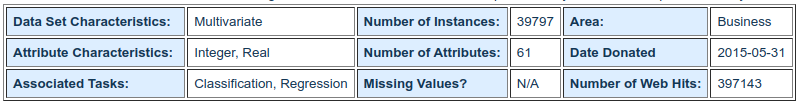

In [ ]:
# Lectura de datos y previsualizacion
file_regression = ruta + "OnlineNewsPopularity.csv"

# Leer los datos
regress_data = leer_datos(file_regression, ",", header = True)
print(f"Dimensiones del dataset (ejemplos, atributos): {regress_data.shape}")

# Visualizar datos
display(regress_data.head())

print("""Ya estamos viendo que url y timedelta son columnas que se deben eliminar.
Ya que son atributos no predictivos""")

Dimensiones del dataset (ejemplos, atributos): (39644, 61)


,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


Ya estamos viendo que url y timedelta son columnas que se deben eliminar.
Ya que son atributos no predictivos


In [ ]:
# Podemos ver más sobre cada atributo: tipo y valores faltantes
regress_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 61 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   url                            39644 non-null  object 
 1   timedelta                      39644 non-null  float64
 2   n_tokens_title                 39644 non-null  float64
 3   n_tokens_content               39644 non-null  float64
 4   n_unique_tokens                39644 non-null  float64
 5   n_non_stop_words               39644 non-null  float64
 6   n_non_stop_unique_tokens       39644 non-null  float64
 7   num_hrefs                      39644 non-null  float64
 8   num_self_hrefs                 39644 non-null  float64
 9   num_imgs                       39644 non-null  float64
 10  num_videos                     39644 non-null  float64
 11  average_token_length           39644 non-null  float64
 12  num_keywords                   39644 non-null 

Tenemos 39644 ejemplos y 61 atributos. La última (`shares`) es el valor a predecir.
Se observa además que hay variables categóricas como `data_channel_is...` que se deberán tratar. Entre ellas hay variables temporales '`weekday_is...`' que seguramente se puedan reducir usando una transformación cíclica. 'is_weekend' debe ser eliminada ya que se dispone de `weekday_is_saturday` y `weekday_is_sunday`. No hay valores faltantes. Hay ciertas características no tan comunes por lo que describen a continuación:

- **data_channel_is_x**: Estas características indican a qué canal de datos pertenece el artículo. Los canales pueden ser diferentes categorías o secciones temáticas dentro del sitio web o plataforma de publicación.

- **kw_x**: Estas características representan la presencia o ausencia de palabras clave específicas en el contenido del artículo. Podríamos analizar qué palabras clave son las más frecuentes y cómo pueden estar relacionadas con la popularidad de los artículos. Por ejemplo, si algunas palabras clave tienen una alta frecuencia en artículos populares, podríamos inferir que están asociadas con temas de interés para los lectores.

- **LDA_0X**: Esta característica está relacionada con un modelo de análisis de tópicos llamado Latent Dirichlet Allocation (LDA). El valor LDA_0X representa la proporción del artículo que se asigna al tópico número X según el modelo LDA. Podríamos analizar qué significa el tópico número X en el contexto del modelo LDA utilizado y cómo puede estar relacionado con la popularidad del artículo. Por ejemplo, si el tópico número 3 está asociado con temas de actualidad o tendencias populares, podría haber una correlación positiva entre el valor de LDA_03 y la cantidad de compartidos.

- **x_polarity**: Esta característica representa la polaridad del contenido del artículo, es decir, si el contenido tiene una connotación positiva, negativa o neutra. Podríamos analizar cómo se distribuyen los valores de polaridad en el conjunto de datos y si hay alguna relación entre la polaridad del contenido y la cantidad de compartidos. Por ejemplo, si los artículos con polaridad positiva tienden a tener más compartidos, podría indicar que los lectores tienen una preferencia por contenido positivo o inspirador.

	Numero de atributos tras eliminar los NO predictivos: 59


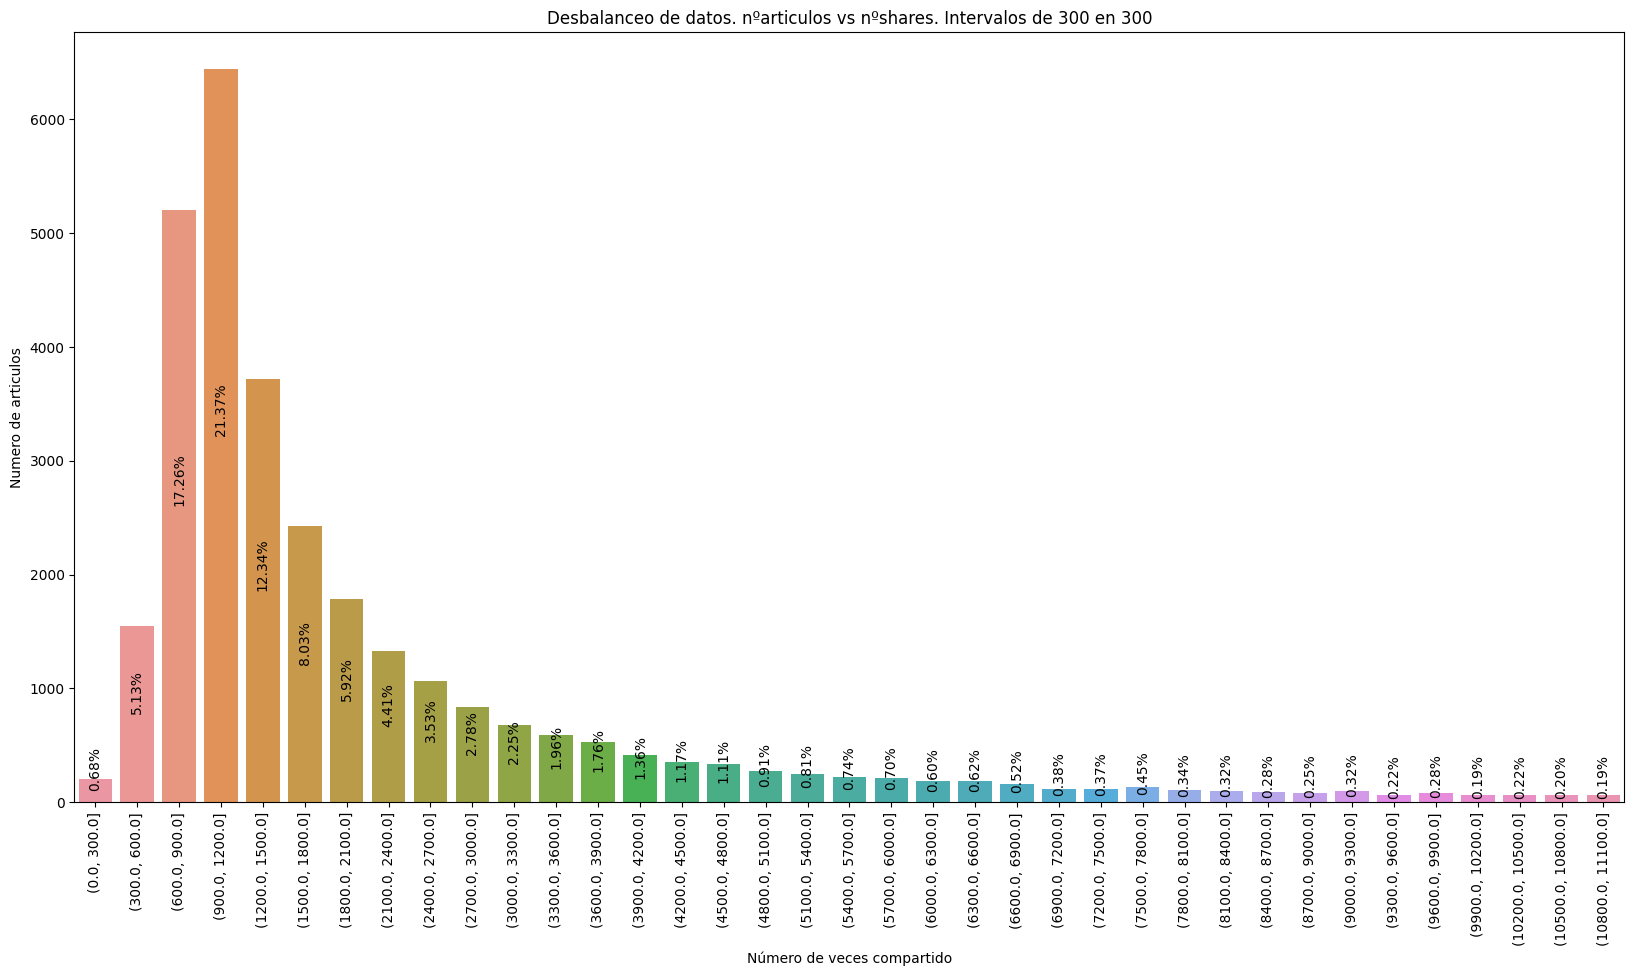

In [ ]:
# Lo primero será eliminar los datos NO predictivos (url y timedelta)
regress_data = regress_data.drop(columns=['url', 'timedelta'], errors='ignore')
print(f"\tNumero de atributos tras eliminar los NO predictivos: {regress_data.shape[1]}")

# Separamos los datos del atributo objetivo
X, Y = separar_datos(regress_data) # Primero se separa en X e Y

# Dividir los datos en training y test usando la libreria scikit
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, shuffle=True)

# Crear dataframes de test y train
train = join_(X_train, Y_train, regress_data.columns)
test = join_(X_test, Y_test, regress_data.columns)

# Visualizamos el objetivo
title = "Desbalanceo de datos. nºarticulos vs nºshares"
xlabel = "Número de veces compartido"
ylabel = "Numero de articulos"
intervalo = 300
percentil = 95
show_histogram(train, title , xlabel, ylabel , intervalo, percentil)

En el contexto del problema de predicción de la popularidad de los artículos en línea, es común observar que la distribución del objetivo (número de veces que se comparte un artículo) sigue una tendencia exponencial o sesgada hacia la izquierda. Esto significa que la mayoría de los artículos tienden a tener un número relativamente bajo de veces compartidas, mientras que unos pocos artículos pueden tener un número extremadamente alto de compartidos.

Cuando se trabaja con distribuciones sesgadas o exponenciales, puede ser beneficioso aplicar una transformación al objetivo para obtener una distribución más cercana a una distribución normal o simétrica. Una transformación comúnmente utilizada es la transformación logarítmica, que implica tomar el logaritmo del objetivo.

En el apartade 4 de preprocesado se detallará como y porqué se realiza esta transformación.

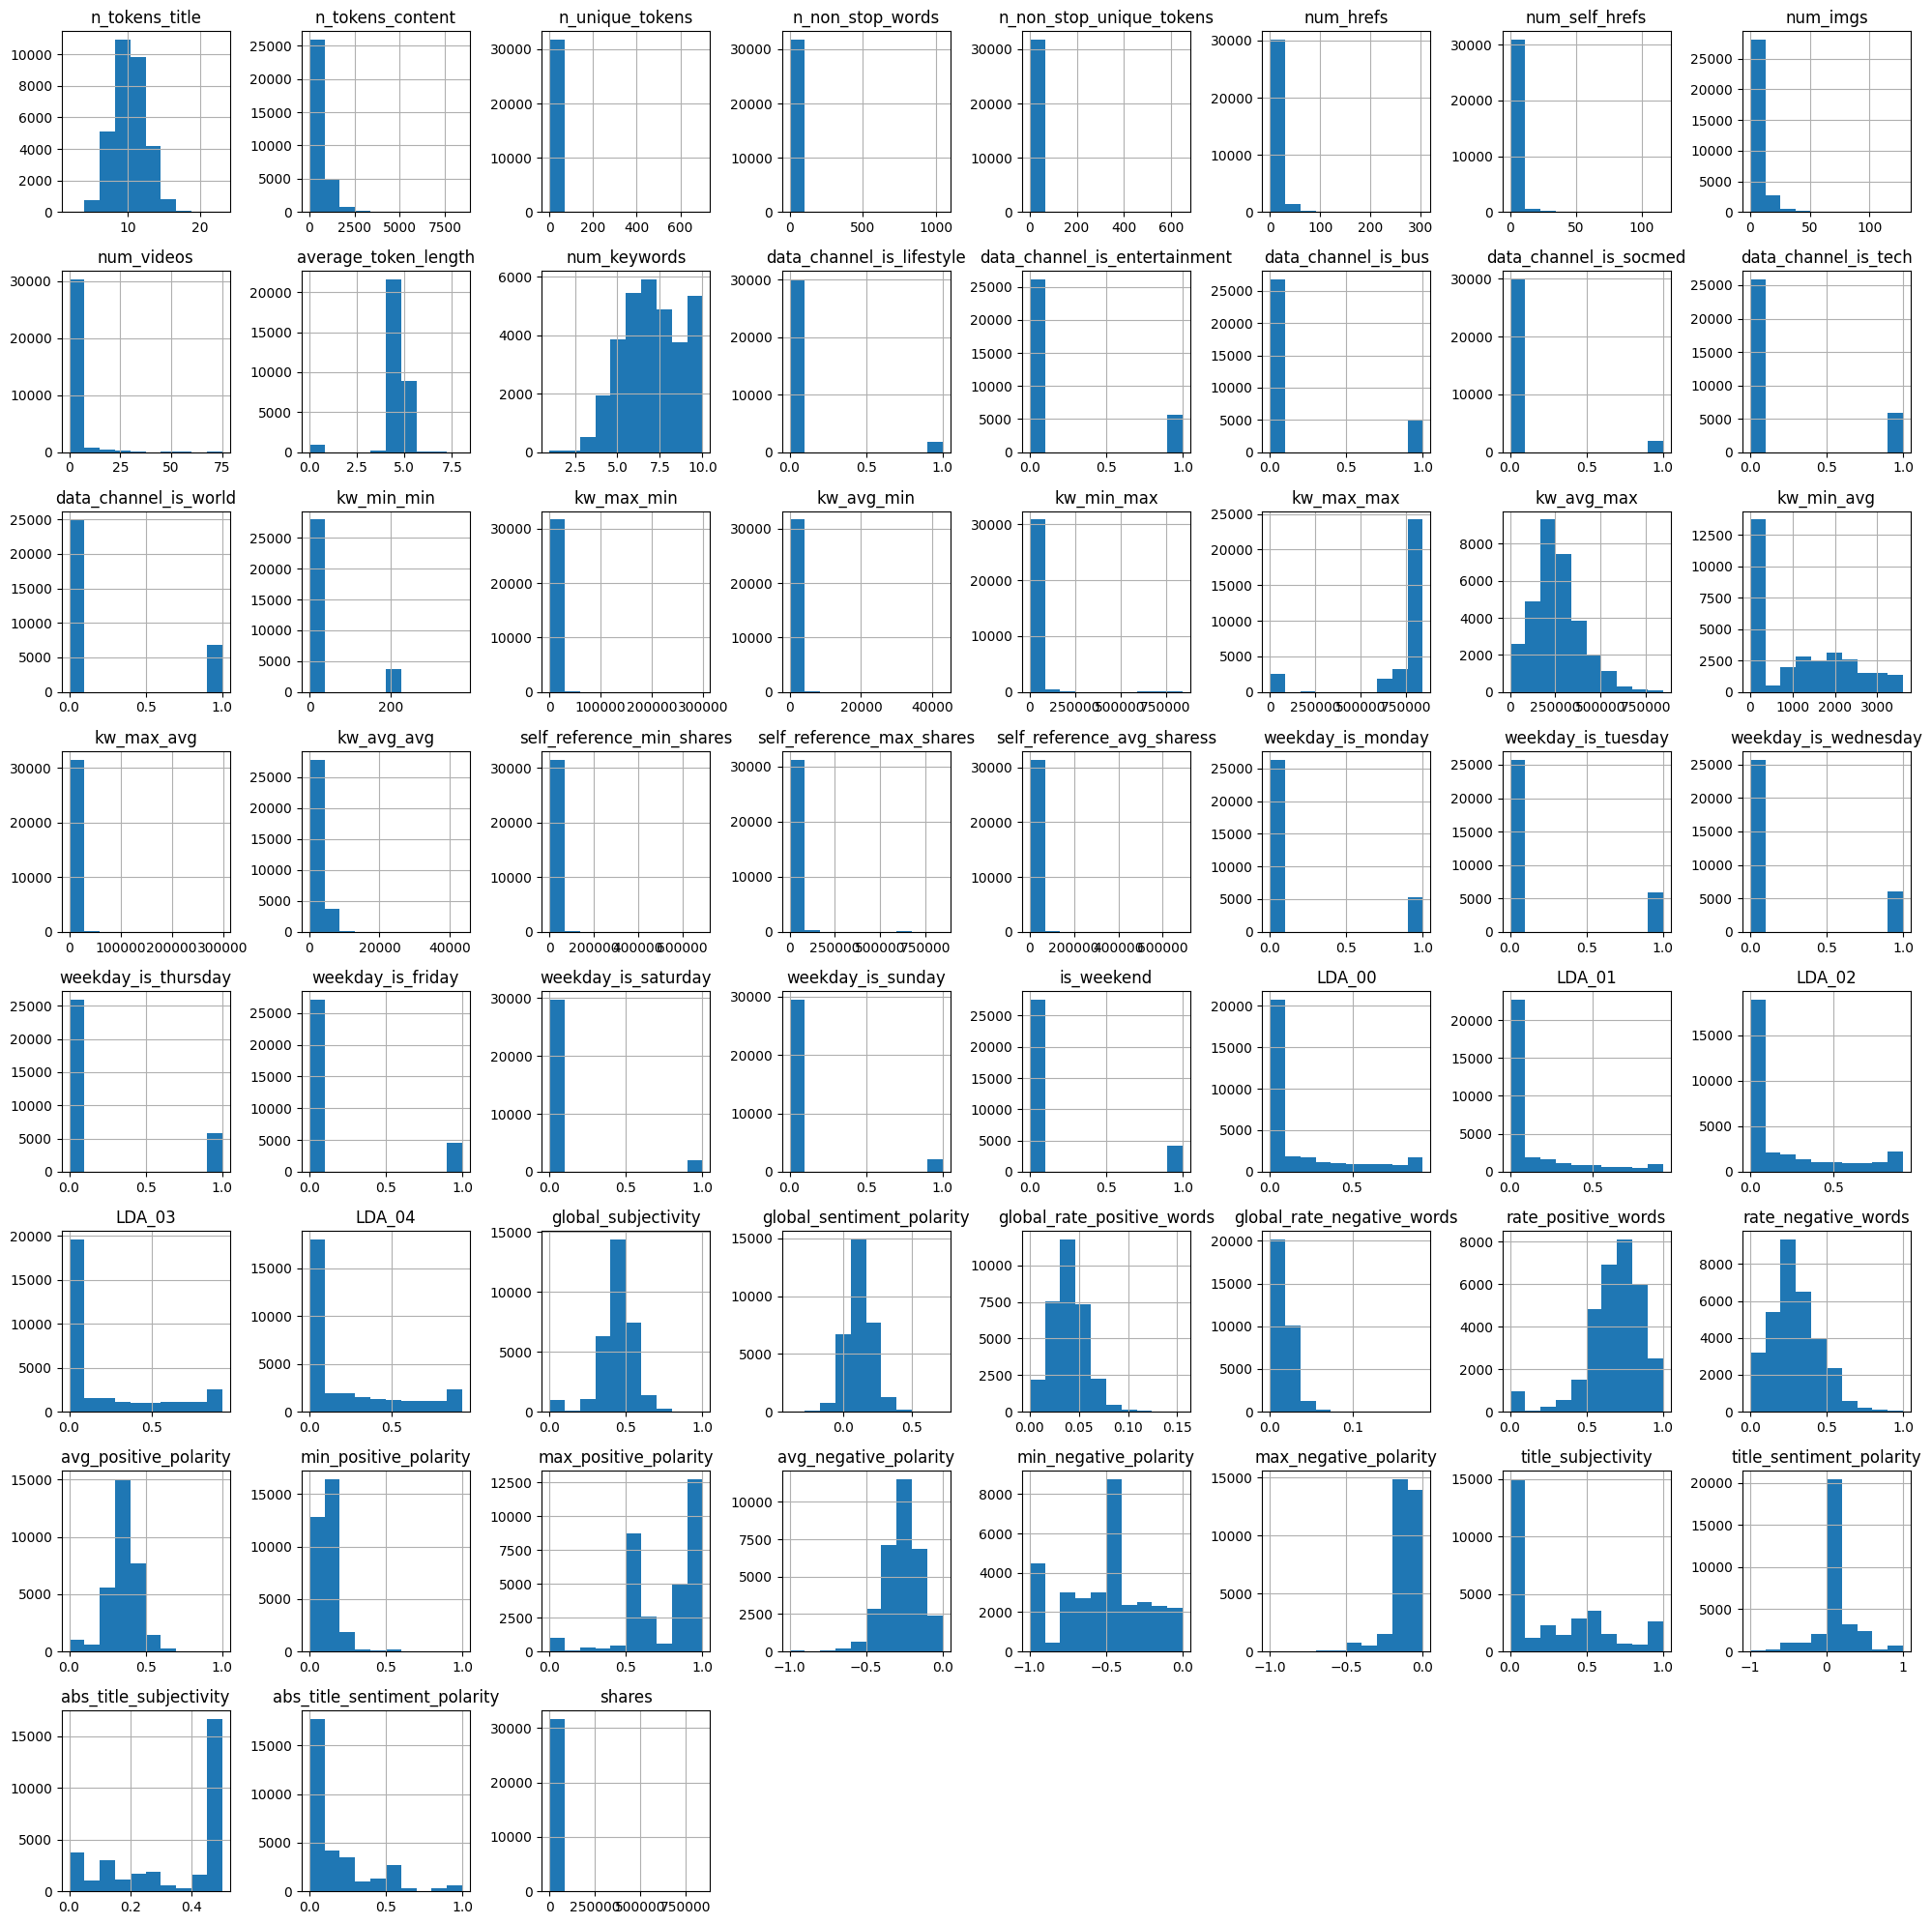

Aqui podemos indentificar claramente las características categóricas.
También vemos las variables que hay que normalizar y cuales tienen valores negativos.
Observación: n_tokens_content representa la cantidad de palabras del artículo,
pues presenta valores en 0 lo cual indica que hay artículos sin texto (vacíos)


In [ ]:
# Visualizamos las caracteristicas
train.hist(figsize=(20,20))
plt.tight_layout()
plt.show()
print("""Aqui podemos indentificar claramente las características categóricas.
También vemos las variables que hay que normalizar y cuales tienen valores negativos.
Observación: n_tokens_content representa la cantidad de palabras del artículo,
pues presenta valores en 0 lo cual indica que hay artículos sin texto (vacíos)""")

A continuación, analizaré algunos posibles hallazgos y observaciones:

- **Número de palabras en el título (n_tokens_title)**: observamos la distribución del número de palabras en el título de los artículos. Vemos una distribución aproximadamente normal, con la mayoría de los títulos que contienen un número moderado de palabras.

- **Número de palabras en el artículo (n_tokens_content)**: Al analizar la distribución del número de palabras en el contenido de los artículos, encontramos una distribución sesgada hacia la izquierda. La mayoría de los artículos tienen un contenido más corto, pero algunos podrían ser excepcionalmente largos.

- **Promedio de palabras en las palabras clave (average_token_length)**: observamos la distribución del promedio de longitud de las palabras clave utilizadas en los artículos. Encontramos una distribución cercana a una distribución normal, con la mayoría de las palabras clave con una longitud promedio moderada.

- **Día de la semana de la publicación (weekday_is_x)**: Para las características relacionadas con el día de la semana de la publicación, como "weekday_is_monday", "weekday_is_tuesday", etc., se observa la distribución de cada día de la semana. Podríamos identificar si hay algún día en particular que sea más común para las publicaciones de noticias. En nuestros datos no se observa ningún día con especial interés.

In [ ]:
# Muestra las variables continuas originales del atributo objetivo
tablaOriginal = crear_tabla_valores(train)
print("\Información relevante del atributo objetivo original")
display(tablaOriginal.tail(1))

\Información relevante del atributo objetivo original


,Media,Mediana,Desviación típica,Mínimo,Máximo,Percentil 10.0,Percentil 25.0,Percentil 50.0,Percentil 75.0,Percentil 90.0
shares,3434.415671,1400.0,12301.454862,1.0,843300.0,708.4,946.0,1400.0,2800.0,6300.0


In [ ]:
# Mostrar resto de datos
titulo = "Valores continuos del resto de atributos"
tabla_valores = tablaOriginal.style.set_caption(titulo).set_table_styles([{'selector': 'caption', 'props': [('font-size', '20px')]}])
display(tabla_valores)

,Media,Mediana,Desviación típica,Mínimo,Máximo,Percentil 10.0,Percentil 25.0,Percentil 50.0,Percentil 75.0,Percentil 90.0
n_tokens_title,10.397541,10.000000,2.113956,2.000000,23.000000,8.000000,9.000000,10.000000,12.000000,13.000000
n_tokens_content,548.914425,411.000000,475.113478,0.000000,8474.000000,153.000000,247.000000,411.000000,718.000000,1089.000000
n_unique_tokens,0.552399,0.538961,3.935684,0.000000,701.000000,0.405921,0.470343,0.538961,0.608527,0.676301
n_non_stop_words,1.003279,1.000000,5.848074,0.000000,1042.000000,1.000000,1.000000,1.000000,1.000000,1.000000
n_non_stop_unique_tokens,0.693118,0.689922,3.649368,0.000000,650.000000,0.552927,0.625352,0.689922,0.754601,0.818713
num_hrefs,10.928110,8.000000,11.370106,0.000000,304.000000,2.000000,4.000000,8.000000,14.000000,23.000000
num_self_hrefs,3.308907,3.000000,3.896201,0.000000,116.000000,0.000000,1.000000,3.000000,4.000000,6.000000
num_imgs,4.557843,1.000000,8.288152,0.000000,128.000000,0.000000,1.000000,1.000000,4.000000,14.000000
num_videos,1.263188,0.000000,4.156885,0.000000,75.000000,0.000000,0.000000,0.000000,1.000000,2.000000
average_token_length,4.550161,4.665714,0.841585,0.000000,8.041534,4.302824,4.479257,4.665714,4.855731,5.037804


A continuación, destacaré algunos aspectos relevantes que podrían surgir al analizar estas estadísticas:

- **Shares (compartidos)**: Al analizar la columna objetivo "shares", podríamos destacar el valor medio y la mediana. Estos valores nos dan una idea de la tendencia central de la distribución de los compartidos. Como la media y la mediana difieren significativamente, nos indican la presencia de valores atípicos o una distribución sesgada.

- **Promedio de palabras en las palabras clave (average_token_length)**: Al analizar la desviación estándar de esta característica, podríamos evaluar la variabilidad en la longitud promedio de las palabras clave utilizadas en los artículos. Como la desviación estándar es baja, nos indica una reducida gama de longitudes de palabras usadas.

- **Número de palabras en el artículo (n_tokens_content)**: Al analizar el percentil 75 (Q3) de esta característica, podríamos identificar la longitud del contenido de los artículos en el cuartil superior. Esto nos da una idea de la extensión de los artículos más largos en el conjunto de datos.

In [ ]:
# Observamos y guardamos las variables categóricas
# Es importante su tratamiento correcto para no aplicar métodos continuos sobre ellas
variables_categoricas = ["weekday_is_monday", "weekday_is_tuesday", "weekday_is_wednesday",
        "weekday_is_thursday", "weekday_is_friday", "weekday_is_saturday",
        "weekday_is_sunday", "is_weekend", "data_channel_is_lifestyle",
        "data_channel_is_entertainment", "data_channel_is_bus",
        "data_channel_is_socmed", "data_channel_is_tech",
        "data_channel_is_world"]

print("Variables categoricas")
display(tablaOriginal.loc[variables_categoricas])

Variables categoricas


,Media,Mediana,Desviación típica,Mínimo,Máximo,Percentil 10.0,Percentil 25.0,Percentil 50.0,Percentil 75.0,Percentil 90.0
weekday_is_monday,0.168721,0.0,0.374512,0.0,1.0,0.0,0.0,0.0,0.0,1.0
weekday_is_tuesday,0.187356,0.0,0.390203,0.0,1.0,0.0,0.0,0.0,0.0,1.0
weekday_is_wednesday,0.188144,0.0,0.390834,0.0,1.0,0.0,0.0,0.0,0.0,1.0
weekday_is_thursday,0.181712,0.0,0.385613,0.0,1.0,0.0,0.0,0.0,0.0,1.0
weekday_is_friday,0.144001,0.0,0.351097,0.0,1.0,0.0,0.0,0.0,0.0,1.0
weekday_is_saturday,0.061201,0.0,0.239703,0.0,1.0,0.0,0.0,0.0,0.0,0.0
weekday_is_sunday,0.068863,0.0,0.253226,0.0,1.0,0.0,0.0,0.0,0.0,0.0
is_weekend,0.130065,0.0,0.336380,0.0,1.0,0.0,0.0,0.0,0.0,1.0
data_channel_is_lifestyle,0.053602,0.0,0.225235,0.0,1.0,0.0,0.0,0.0,0.0,0.0
data_channel_is_entertainment,0.177203,0.0,0.381847,0.0,1.0,0.0,0.0,0.0,0.0,1.0


Podemos realizar algunas observaciones:

- `weekday_is_monday, weekday_is_tuesday, weekday_is_wednesday, weekday_is_thursday, weekday_is_friday, weekday_is_saturday, weekday_is_sunday, is_weekend`: Estas variables indican si un artículo de noticias se publicó en un determinado día de la semana. Según los percentiles, la mayoría de los artículos no se publican los fines de semana, ya que los valores del percentil 75 y el percentil 90 son 0. También podemos ver que la mediana y la media para estas variables son bastante bajas, lo que indica que los artículos de noticias tienden a distribuirse de manera bastante uniforme a lo largo de la semana.

- `data_channel_is_lifestyle, data_channel_is_entertainment, data_channel_is_bus, data_channel_is_socmed, data_channel_is_tech, data_channel_is_world`: Estas variables representan diferentes canales o categorías de noticias. Según los valores mostrados, podemos ver que algunas categorías, como "data_channel_is_world" y "data_channel_is_tech", tienen una mayor proporción de artículos de noticias, como se indica por la media siendo 0.40 y 0.38 respectivamente. Por otro lado, "data_channel_is_lifestyle" y "data_channel_is_socmed" tienen una proporción más baja de artículos de noticias, ya que todos los percentiles son 0. Las otras categorías están presentes en alguna medida, pero pueden tener una distribución más equilibrada.

En resumen, las variables categóricas proporcionan información sobre el día de la semana en que se publicaron los artículos de noticias y las diferentes categorías o canales a los que pertenecen. Estas variables pueden ser útiles para realizar análisis adicionales y comprender mejor los patrones de distribución de los artículos de noticias según los días de la semana y las categorías específicas.

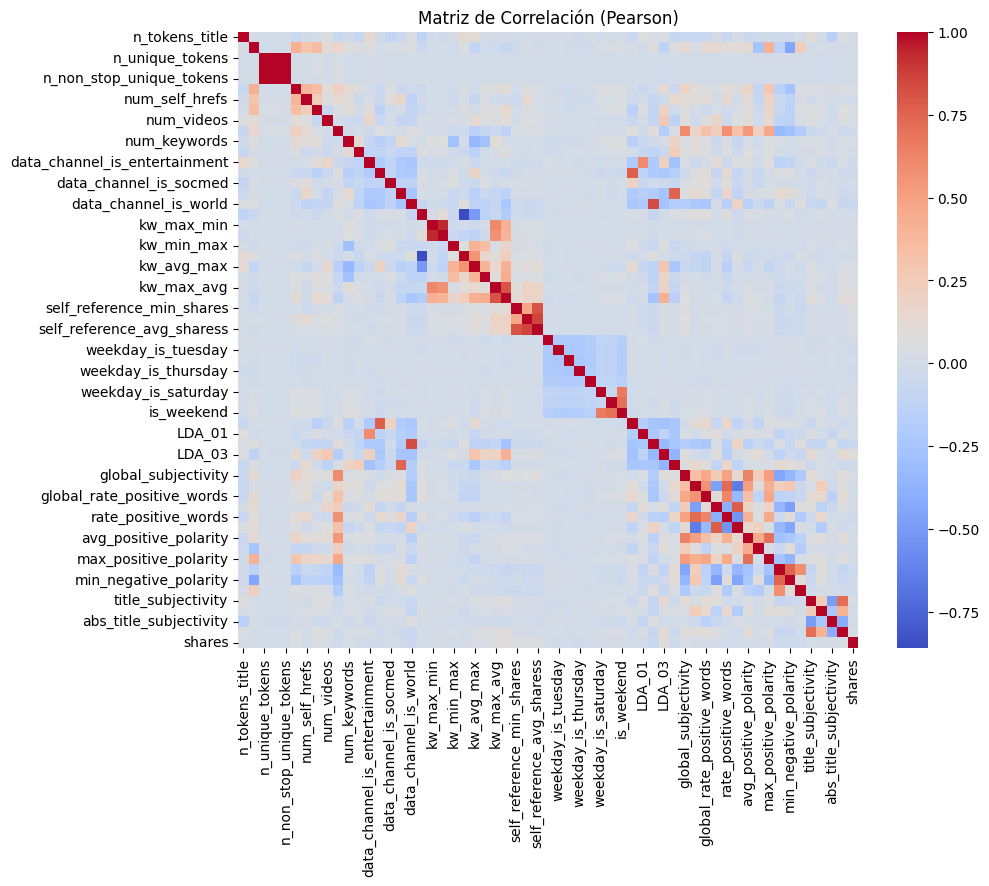

In [ ]:
# Visualizamos la correlacion de los datos

# Calcular la matriz de correlación de Pearson
pearson_corr = train.corr(method='pearson')

# Calcular la matriz de correlación de Spearman
#spearman_corr = train.corr(method='spearman') # Redundante

# Crear un mapa de calor de la matriz de correlación de Pearson
plt.figure(figsize=(10, 8))
sns.heatmap(pearson_corr, annot=False, cmap='coolwarm', annot_kws={"size": 8})
plt.title('Matriz de Correlación (Pearson)')
plt.show()

Vemos que hay pares de variables que están muy correlacionadas como el par n_unique_tokens y n_non_stop_unique_tokens. La alta correlación entre estas variables sugiere una fuerte relación entre ellas, lo que significa que están capturando información similar o relacionada.

La correlación es una medida estadística que indica la relación entre dos variables. Puede variar en valor entre 0 y 1. Una correlación de 1 indica una correlación positiva perfecta, lo que significa que las variables se mueven en la misma dirección. Una correlación de 0 indica una correlación nula, lo que significa que las variables son independientes entre sí.

En el caso de "n_unique_tokens" y "n_non_stop_unique_tokens", si tienen una alta correlación positiva, significa que cuando el valor de una variable aumenta, es probable que el valor de la otra variable también aumente, y viceversa.

Cuando hay pares de variables altamente correlacionadas, es importante tenerlo en cuenta durante el análisis de los datos. La alta correlación puede sugerir multicolinealidad, lo que puede afectar la interpretación de los modelos y la selección de características. En tales casos, hay que considerar la eliminación de una de las variables altamente correlacionadas o utilizar técnicas de reducción de dimensionalidad, como el análisis de componentes principales (PCA), para reducir la redundancia y la dimensionalidad de los datos.

In [ ]:
# Eliminamos variables con una alta correlación

# Crear un diccionario para almacenar los pares de columnas con correlación superior a 0.9
pares_corr = {}

# Obtener las dimensiones del DataFrame
num_filas, num_columnas = pearson_corr.shape

# Iterar sobre las columnas del DataFrame
for i in range(num_columnas):
    for j in range(i+1, num_columnas):
        # Verificar si la correlación es mayor a 0.9
        if abs(pearson_corr.iloc[i, j]) > 0.9:
            # Almacenar el par de columnas con la correlación en el diccionario
            columna_1 = pearson_corr.columns[i]
            columna_2 = pearson_corr.columns[j]
            pares_corr[(columna_1, columna_2)] = pearson_corr.iloc[i, j]

# Mostrar los pares de columnas con correlación superior a 0.9
for pares, correlacion in pares_corr.items():
    columna_1, columna_2 = pares
    print(f"Columna 1: {columna_1}, Columna 2: {columna_2}, Correlación: {correlacion}")

print("Atributos originales en los datos: ", train.shape[1])
train = train.drop(["n_non_stop_unique_tokens","n_non_stop_words","kw_avg_min","rate_negative_words"],axis=1, errors='ignore')
test = test.drop(["n_non_stop_unique_tokens","n_non_stop_words","kw_avg_min","rate_negative_words"],axis=1, errors='ignore')
print("Atributos tras eliminar correlados en los datos: ", train.shape[1])

Columna 1: n_unique_tokens, Columna 2: n_non_stop_words, Correlación: 0.999655872545394
Columna 1: n_unique_tokens, Columna 2: n_non_stop_unique_tokens, Correlación: 0.9998816138279542
Columna 1: n_non_stop_words, Columna 2: n_non_stop_unique_tokens, Correlación: 0.9996232337006388
Columna 1: kw_max_min, Columna 2: kw_avg_min, Correlación: 0.9386867309755983
Atributos originales en los datos:  59
Atributos tras eliminar correlados en los datos:  55


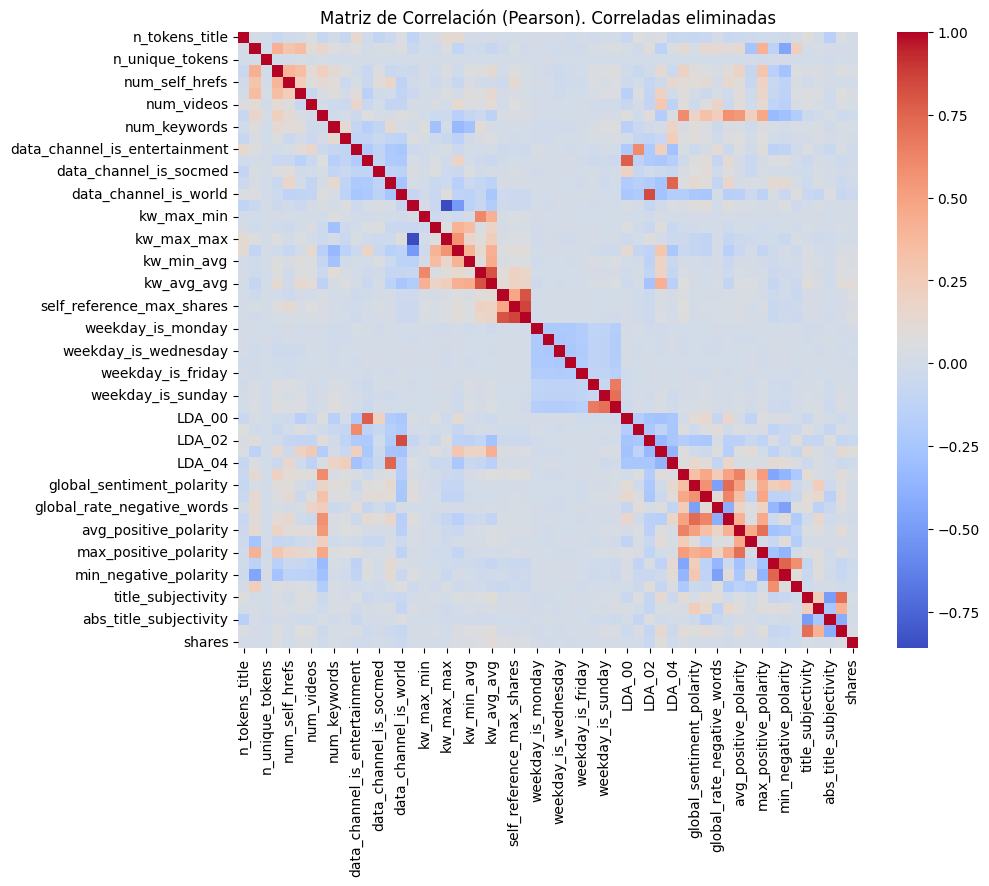

In [ ]:
# Calcular la matriz de correlación de Pearson
pearson_corr = train.corr(method='pearson')

# Crear un mapa de calor de la matriz de correlación de Pearson
plt.figure(figsize=(10, 8))
sns.heatmap(pearson_corr, annot=False, cmap='coolwarm', annot_kws={"size": 8})
plt.title('Matriz de Correlación (Pearson). Correladas eliminadas')
plt.show()
# Iterar sobre las columnas del DataFrame

#### <font color='blue'>2)  Identificar qué conjuntos de hipótesis se emplearán

---

y justificar dicha elección. 0.25 puntos.

Para esta ocasión se pide aplicar solo modelos lineales. Aun así, no tendría sentido aplicar combinaciones no lineales a los datos ya que podría llevar a problemas de Overfitting.

Vamos a analizar los tres modelos propuestos:

- **La regresión Lineal** estudia la relación entre dos o más variables para predecir un comportamiento, lo que parece idóneo para este problema, ya que se busca que, analizando una serie de atributos, se prediga cuantas veces será compartido un artículo.

- **La Regresión logística**, a diferencia de la regresión lineal, se utiliza principalmente para problemas de clasificación binaria. Como el objetivo de la práctica es realizar una predicción o modelado de una variable continua ('número de shares') la regresión logística no sería el modelo adecuado. La regresión logística se enfoca en estimar la probabilidad de pertenecer a una clase, no en predecir valores continuos.

- **El Perceptrón+pocket** también se utiliza para clasificación binaria cuando los datos son linealmente separables. No se utiliza para problemas de regresión lineal, donde se busca predecir un valor continuo. Como el objetivo de la práctica es realizar una predicción numérica, el perceptrón+pocket no sería la elección adecuada.

>Además la regresión lineal presenta las siguientes virtudes:

- Simplicidad: No requiere de una gran cantidad de parámetros ni de técnicas sofisticadas para su implementación.

- Interpretación: La regresión lineal proporciona coeficientes que permiten interpretar el impacto relativo de cada variable independiente en la variable dependiente. Esto puede ser útil para comprender cómo diferentes variables están relacionadas entre sí y cómo influyen en el resultado.

- Flexibilidad: Incluso con su simplicidad, la regresión lineal puede ser aplicada en un amplio abanico de problemas de predicción. Es un modelo versátil que puede adaptarse a diferentes situaciones y datos.

- Eficiencia computacional: Comparado con otros modelos más complejos, la regresión lineal tiende a ser computacionalmente más eficiente. Esto significa que puede ser adecuado para conjuntos de datos más grandes o cuando se necesita obtener resultados rápidamente.

Por tanto el modelo que utilizaré para la práctica será la **regresión Lineal**.

#### <font color='blue'>3)  Si la base de datos define conjuntos de training y test, únalos en un solo conjunto y genere sus propios conjuntos. Describa y justifique el mecanismo de partición. 0.75 puntos.

En este caso, el problema en cuestión no proporcionaba ninguna división física en ficheros entre train y test de los datos.  Para realizar esta partición se ha tomado el conjunto completo de datos y se han elegido qué porcentajes del total formarán parte de una parte y de otra. Se ha elegido que el 20 % formará parte del conjunto Test, mientras que el restante 80 % lo será del Train quedando:

- Train. 31715 elementos del conjunto de datos.
- Test. 7929 elementos.

Para hacer esto, en el primer apartado se ha hecho uso de la función de `sklearn`:

 `train_test_split(X, Y, test_size = 0.2, shuffle=True)`

 Indicando en sus parámetros el mezclado de datos mediante shuffle, de forma que el 80 % no sea los primeros elementos y el resto los últimos, si no que antes haga una mezcla de los mismos.

Dentro del conjunto de entrenamiento podemos aplicar diferentes técnicas como el leave one out, hold out o cross validation o una mezcla de varios. Vamos a analizar cada uno:

-  **Cross Validation (CV)**: En lugar de dividir el conjunto de datos en una única partición de entrenamiento y prueba, cross validation divide el conjunto de datos en k particiones o "folds" de tamaño similar. El objetivo es evaluar el rendimiento del modelo de forma más robusta, ya que se utiliza la totalidad de los datos en múltiples combinaciones de entrenamiento y prueba. Esto permite obtener una estimación más confiable del rendimiento del modelo y evaluar cómo se generaliza a datos no vistos.

- **Leave one out**: es una técnica de validación cruzada extremadamente costosa computacionalmente, ya que implica entrenar el modelo tantas veces como el número de muestras en el conjunto de entrenamiento. En nuestro caso que hay unas 30.000 instancias de entrenamiento no es recomendable.

- **Hold out**: implica dividir el conjunto de datos en dos partes: entrenamiento y validación. Si los datos presentan una distribución no uniforme o existe una variabilidad significativa en los datos, la partición realizada en hold out puede introducir un sesgo en la evaluación del modelo. Y como hemos visto, nuestros datos tienen un desbalanceo importante por lo que no es recomendable usarlo. En cambio, el uso de cross validation permite evaluar el rendimiento del modelo en diferentes subconjuntos de datos, lo que ayuda a mitigar el impacto de esa variabilidad.

Los motivos extra por los que usar cross validation son:

 - Mayor aprovechamiento de los datos: ya que permite utilizar la totalidad de los datos de entrenamiento en múltiples iteraciones, lo que resulta en un mejor aprovechamiento del conjunto de entrenamiento disponible.

- Evaluación más fiable del modelo: al realizar múltiples particiones del conjunto de datos y promediar los resultados, CV proporciona una estimación más fiable del rendimiento del modelo. Permite evaluar cómo se generaliza el modelo en diferentes configuraciones de los datos y ayuda a mitigar el impacto de una partición de datos específica en los resultados finales.

- Ajuste de hiperparámetros: permite evaluar diferentes combinaciones de hiperparámetros en múltiples divisiones del conjunto de entrenamiento, lo que ayuda a seleccionar los mejores hiperparámetros de manera más confiable.

Para aplicar el cross validation se ha implementado un método propio

`kfold_cross_validation(estimator, X, y, scoring=None, cv=None, shuffle=False, media=False)`

Como parámetros recibe:
- estimator: el modelo al que se le aplica CV
- X e Y: representan los datos y objetivo
- scoring: indica que métodos de evaluación se usan. Pueden ser mse, mae o r2.
- cv: indica que se realizará una validación cruzada de 5-fold.
- Shuffle: indica si se quiere mezclar o no el conjunto de datos antes.
- media: indica si devuelve la media o el mejor resultado del estimador.
- transformacion: indica si el objetivo están transformado (logaritmo).
Para regularización se incluye el CV en los modelos.

In [ ]:
# Funciones auxiliares asociadas al método de CV

# Gráfica comparativa entre objetivo Test y Predicciones
def show_prediction(Y_t, predicts, title):
  # Crear la gráfica de puntos
  plt.scatter(range(len(Y_t)), Y_t, color='blue', label='Valores reales')

  # Dibujar la línea con los valores predichos
  plt.plot(range(len(predicts)), predicts, color='red', label='Valores predichos', marker='o', linestyle='-')

  # Añadir etiquetas y leyenda
  plt.title(title)
  plt.xlabel('Articulo')
  plt.ylabel('Shares')
  plt.legend(loc="upper right")
  plt.legend()

  # Mostrar la gráfica
  plt.show()

"""
La fórmula para la regresión lineal con una sola variable x es:
  y = mx + b

Pero si tiene multiples variables, entonces es:
  Y = b + m1 · X1 + m2 · X2 + … + m(n) · X(n)
"""
def evaluate_model(YTest, predictions, title="", show_prints=True, show_grafica=False):
    # Calcular el MSE (Error Cuadrático Medio)
    mse = mean_squared_error(YTest, predictions)

    # Calcular el MAE (Error Absoluto Medio)
    mae = mean_absolute_error(YTest, predictions)

    # Calcular el coeficiente de determinación R2
    r2 = r2_score(YTest, predictions)

    if show_prints:
      print("\n\tError Cuadrático Medio (MSE): ", mse) # El error perfecto es 0
      print("\n\tError Absoluto Medio (MAE): ", mae)
      print("\n\tCoeficiente de Determinación R2 [0, 1]: ", r2)

    # Graficar prediccion vs datos reales
    if show_grafica:
      show_prediction(YTest, predictions, f"{title}. Datos reales vs prediccion")

    return mse, mae, r2

In [ ]:
# Implementación CV manual
def kfold_cross_validation(estimator, X, y, scoring=None, cv=None, ein=False, show_graficas=True, transformacion=False):
    """
    estimator: Estimador/modelo a utilizar.
    X: Datos de entrada.
    y: Objetivo correspondiente a los datos de entrada.
    scoring: Métrica de evaluación a utilizar (por defecto None).
    cv: Número de divisiones para la validación cruzada (por defecto None).
    shuffle: Indica si se realiza un reordenamiento aleatorio de los datos antes de la validación cruzada (por defecto True).
    media: Indica si se calcula la media de las métricas de evaluación obtenidas en cada fold (por defecto True).
    transformacion: Indica si se realiza una transformación a escala real de los datos (por defecto False).
    show_graficas: Indica si se muestran las gráficas de resultados (por defecto True).
    """
    scores = []
    n_samples = len(X)
    fold_size = n_samples // cv

    resultados = [] # Almacena métricas
    evaluaciones = [] # Almacena prediccion e Y
    cv_score = {}

    # Guarda si es las métricas son del conjunto de prueba o entrenamiento
    error="Ein" if ein else "Validation score"

    # Mezclar X e y manteniendo la correspondencia
    data = pd.concat([X, y], axis=1)
    data_shuffled = data.sample(frac=1).reset_index(drop=True)

    # Separar X y y nuevamente
    X = data_shuffled.iloc[:, :-1]  # Todas las columnas excepto la última
    y = data_shuffled.iloc[:, -1]   # Última columna (target)

    for i in range(cv):
        # Dividir los datos en conjunto de entrenamiento y prueba para esta iteración
        start = i * fold_size
        end = start + fold_size

        Xtrain = np.concatenate((X[:start].values, X[end:].values), axis=0)
        ytrain = np.concatenate((y[:start].values, y[end:].values), axis=0)
        Xtest = X[start:end].values
        ytest = y[start:end].values

        # Entrenar el estimador en el conjunto de entrenamiento y obtener la puntuación en el conjunto de prueba

        # Ajustar el modelo con los datos de entrenamiento
        ajuste = estimator.fit(Xtrain, ytrain)

        # Realizar las predicciones en el conjunto de prueba (train si calculate_ein=True)
        if ein:
          pred = ajuste.predict(Xtrain)
          Y = ytrain
        else:
          pred = ajuste.predict(Xtest)
          Y = ytest

        # Detransformar a exponencial
        if transformacion:
          pred = np.expm1(pred) # Transforma la prediccion a la escala real
          Y = np.expm1(ytrain) if ein else np.expm1(ytest)

        # Evaluar el modelo utilizando las métricas de evaluación
        resultado = evaluate_model(Y, pred, "", False)

        evaluaciones.append([Y, pred])
        resultados.append(resultado)

    resultados = np.array(resultados)

    metricas = np.mean(resultados, axis=0) # Media
    evaluacion = np.mean(evaluaciones, axis=0)

    if show_graficas:
      show_prediction(*evaluaciones[0], f"{error}. Shares test vs prediccion")

    for i, score in enumerate(scoring):
        cv_score[score] = metricas[i]

    # Imprimir si estamos calculando metricas en train o test
    print("Calculando: ", error)

    return cv_score

In [ ]:
# la separacion de train se realiza al principio en el apartado 1

print("\tTamaño del Conjunto")
print("\t\t", X.shape)

print("\n\tTamaño del Train")
print("\t\t", X_train.shape)

print("\n\tTamaño del Test")
print("\t\t", X_test.shape)

# El cross validation se aplica en el apartado 6

	Tamaño del Conjunto
		 (39644, 58)

	Tamaño del Train
		 (31715, 58)

	Tamaño del Test
		 (7929, 58)


#### <font color='blue'>4)  Justifique todos los detalles del preprocesado de los datos (codificación, transformación, normalización, etc). Es decir, todas las manipulaciones sobre los datos iniciales que nos permitan fijar el conjunto de vectores de características que se usarán en el entrenamiento. 1 punto.

<font color='blue'>Nota: Las transformaciones no-lineales de las variables pueden definirse a partir de las potencias y
productos de potencias de las variables originales, conjuntos de polinomios ortogonales, etc. Si se
usan transformaciones no polinómicas de las variable como $log$, $\sqrt{()}$, $sin$, etc, debe justificar el
interés de las mismas.

Comprobar la presencia de valores incoherentes (Nan, negativos) en los datos es importante por varias razones:

- Afecta la integridad de los datos y puede introducir sesgos en el análisis.
- Puede afectar la precisión del modelo y producir resultados incorrectos.
- Requiere una atención especial en términos de manejo de los valores faltantes.
- Garantiza la calidad de los datos y resultados precisos en el análisis o modelado posterior.

Para comprobar si hay Nan en un DataFrame, se utiliza el método isna() seguido del método any().

Para comprobar si hay valores negativos en un DataFrame, se utiliza el método lt.(0) seguido del método any().

In [ ]:
# Comprobar si hay valores faltantes en el conjunto de entrenamiento
missing_train = train.isna().any()
# Comprobar si hay valores faltantes en el conjunto de prueba
missing_test = test.isna().any()

# Verificar si hay valores faltantes en el conjunto de entrenamiento
if missing_train.any():
    print("El conjunto de entrenamiento contiene valores faltantes en las siguientes columnas:")
    print(missing_train[missing_train].index)
else:
    print("No hay valores faltantes en el conjunto de entrenamiento.")

# Verificar si hay valores faltantes en el conjunto de prueba
if missing_test.any():
    print("El conjunto de prueba contiene valores faltantes en las siguientes columnas:")
    print(missing_test[missing_test].index)
else:
    print("No hay valores faltantes en el conjunto de prueba.")

# Verificar qué columnas tienen valores negativos
columnas_con_negativos = train.lt(0).any()

# Obtener los nombres de las columnas con valores negativos
columnas_negativas = columnas_con_negativos[columnas_con_negativos].index.tolist()

print("Columnas con valores negativos:", columnas_negativas)

No hay valores faltantes en el conjunto de entrenamiento.
No hay valores faltantes en el conjunto de prueba.
Columnas con valores negativos: ['kw_min_min', 'kw_min_avg', 'global_sentiment_polarity', 'avg_negative_polarity', 'min_negative_polarity', 'max_negative_polarity', 'title_sentiment_polarity']


 El atributo "kw_min_min" implica que representa el valor mínimo de las métricas relacionadas con la palabra clave y la cantidad mínima de veces que se comparte un artículo. Como la cantidad de veces que se comparte un artículo no puede ser negativa, 'kw_min_min' no puede tener valores negativos en condiciones normales.
 Lo mismo se aplica para kw_min_avg por lo que se eliminan los valores negativos de dichas columnas.

 Los atributos x_polarity si pueden contener valores negativos por lo que no se modifican.

In [ ]:
# Eliminar ejemplos con kw_min negativos
train = train[(train['kw_min_min'] >= 0) & (train['kw_min_avg'] >= 0)]
test = test[(test['kw_min_min'] >= 0) & (test['kw_min_avg'] >= 0)]

# Verificar qué columnas tienen valores negativos
columnas_con_negativos = train.lt(0).any()

# Obtener los nombres de las columnas con valores negativos
columnas_negativas = columnas_con_negativos[columnas_con_negativos].index.tolist()

print("Columnas con valores negativos tras eliminarlos de kw_min:\n", columnas_negativas)

Columnas con valores negativos tras eliminarlos de kw_min:
 ['global_sentiment_polarity', 'avg_negative_polarity', 'min_negative_polarity', 'max_negative_polarity', 'title_sentiment_polarity']


Vamos a investigar las posibles transformaciones de los datos:

- **Transformación logarítmica**: Tomar el logaritmo de una variable puede ser útil cuando se sospecha una relación exponencial entre la variable y la variable objetivo. Por ejemplo, en problemas donde la variable objetivo tiene una tendencia exponencial, como los precios de los pisos (especialmente capitales).

- **Transformación de raíz cuadrada**: Tomar la raíz cuadrada de una variable puede ser útil cuando se desea disminuir el efecto de valores atípicos o cuando se sospecha una relación no lineal con la variable objetivo. Esto puede ayudar a estabilizar la varianza y linealizar la relación.

- **Transformación de potencia**: Elevar una variable a una potencia, como el cuadrado o el cubo, puede ayudar a capturar relaciones no lineales. Por ejemplo, si se sospecha una relación cúbica entre la variable y la variable objetivo, se puede elevar la variable al cubo.

- **Transformación trigonométrica**: Aplicar funciones trigonométricas como el seno o el coseno a una variable puede ser útil para modelar patrones periódicos o estacionales en los datos. Esto es especialmente útil en problemas de series temporales. En este caso la única variable periodica sería el deltatime y ha sido eliminado por lo que no tendría sentido usar esta transformación.

Para abordar el _desbalanceo exponencial_ en el objetivo, se puede aplicar una transformación utilizando logaritmos naturales (ln). Al aplicar el logaritmo natural, se nivelan las distribuciones del objetivo, reduciendo el impacto de valores extremos. Sin embargo, esta transformación solo se aplica al objetivo, no a las variables independientes. Antes de llamar al modelo para realizar predicciones en nuevos datos, es necesario revertir la transformación aplicando la función exponencial a las predicciones transformadas. Esto permite interpretar las predicciones en la escala y distribución originales del objetivo. Esta transformación se aplica tanto en el conjunto de entrenamiento como en el conjunto de prueba.

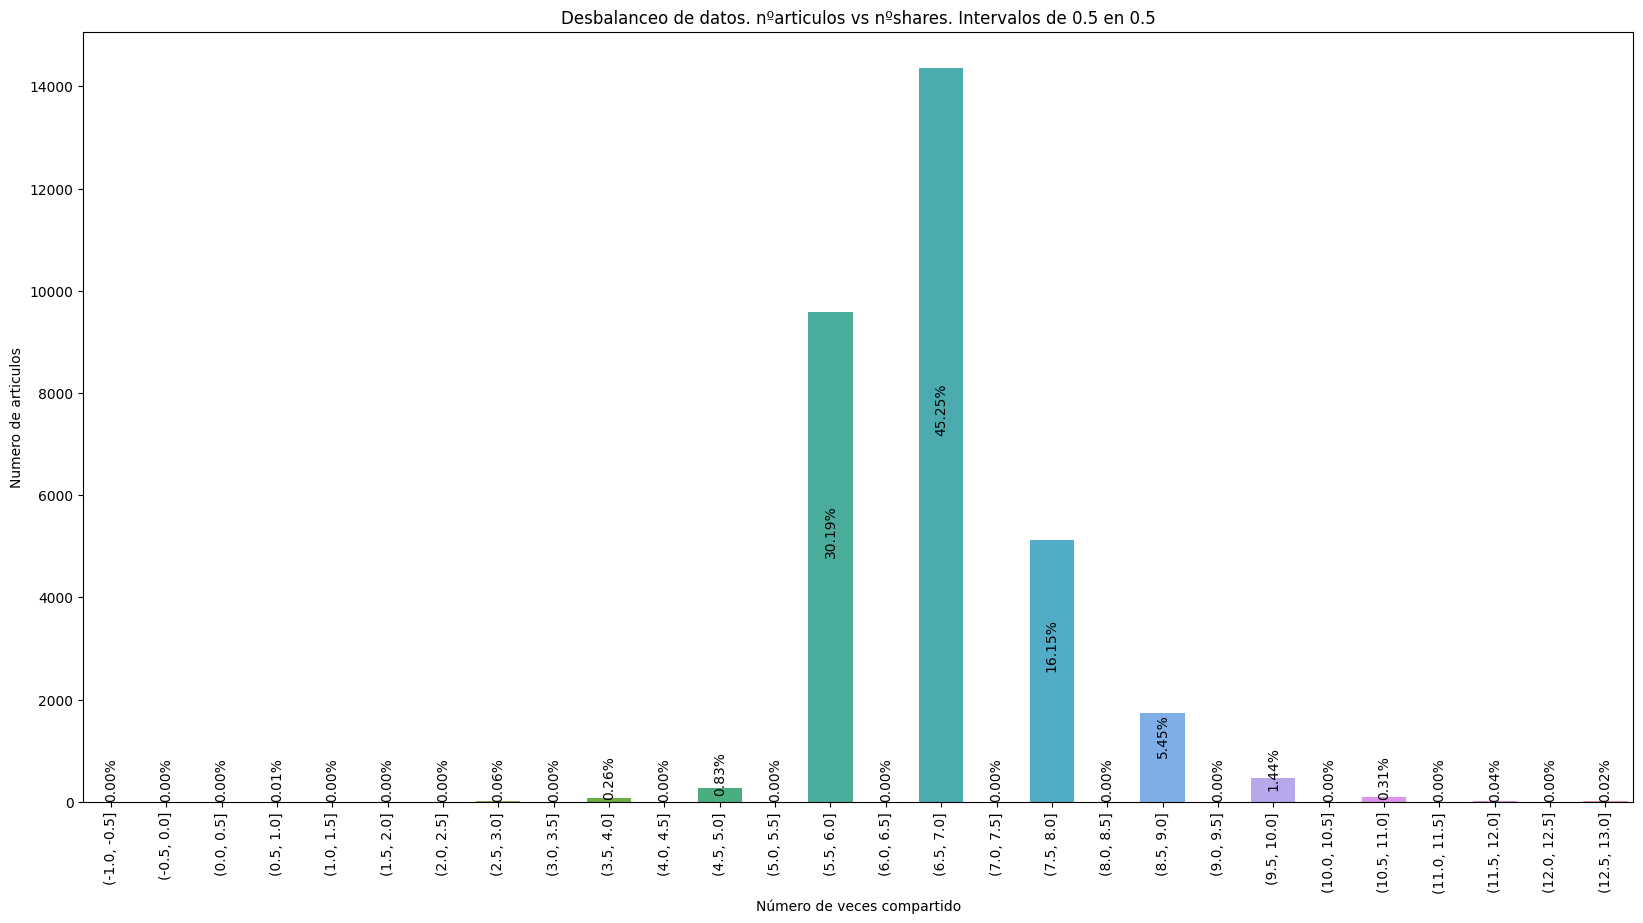

In [ ]:
# Arreglamos el desbalanceo de datos
# Convertir el objetivo exponencial a polinomial usando logaritmos
Y_train_trans = np.log1p(Y_train) # Transforma el objetivo de exponencial a parabólica
Y_test_trans = np.log1p(Y_test) # Transforma el objetivo de exponencial a parabólica

# Crear dataframes de train y test
train = join_(X_train, Y_train_trans, regress_data.columns)
test = join_(X_test, Y_test_trans, regress_data.columns)

# Muestra el histograma tras corregir el desbalanceo de datos
title = "Desbalanceo de datos. nºarticulos vs nºshares"
xlabel = "Número de veces compartido"
ylabel = "Numero de articulos"
intervalo = 0.5
percentil = 100 # todos los datos
show_histogram(train, title , xlabel, ylabel, intervalo, percentil)

In [ ]:
# Muestra las variables continuas de las etiquetas balanceadas
tablaActual = crear_tabla_valores(train)
print("\nResumen del objetivo balanceado")
display(tablaActual.tail(1))


Resumen del objetivo balanceado


,Media,Mediana,Desviación típica,Mínimo,Máximo,Percentil 10.0,Percentil 25.0,Percentil 50.0,Percentil 75.0,Percentil 90.0
shares,7.477626,7.244942,0.932248,0.693147,13.645079,6.564419,6.853299,7.244942,7.937732,8.748464


La **transformación trigonométrica** utilizando las funciones seno y coseno se utiliza para capturar la naturaleza cíclica de las variables. En el caso de las columnas "is_weekday", que representan los días de la semana, los valores oscilan en un ciclo repetitivo de 7 días. Al aplicar la transformación trigonométrica, se puede representar esta periodicidad mediante dos nuevas columnas: "weekday_sin" y "weekday_cos".

- La columna "weekday_sin" representa la posición angular del día de la semana en relación con un círculo unitario utilizando la función seno. Esta columna captura la componente sinusoidal del ciclo y permite modelar la relación cíclica de los días de la semana.

- La columna "weekday_cos" representa la posición angular del día de la semana en relación con un círculo unitario utilizando la función coseno. Esta columna captura la componente cosinusoidal del ciclo y también contribuye a modelar la relación cíclica de los días de la semana.

La combinación de ambas columnas, "weekday_sin" y "weekday_cos", permite representar la información cíclica de los días de la semana de manera más completa que simplemente utilizando una única columna categórica. Al incluir ambas componentes trigonométricas, el modelo de aprendizaje automático tiene la capacidad de capturar patrones más precisos y realizar predicciones más acertadas.

Eliminar las columnas originales "is_weekday" después de crear las columnas "weekday_sin" y "weekday_cos" es necesario para evitar la multicolinealidad en el modelo.

In [ ]:
# Transformar datos temporales
def transformar_weekdays(X, tabla=True):
  X_t = X.drop(["is_weekend"],axis=1)

  Wday = X_t.iloc[:, 29:36]
  # Transformar las columnas en seno y coseno y eliminar las originales

  # Calcular ángulo en radianes para cada día de la semana
  angulos = (2 * np.pi * np.arange(7)) / 7

  # Calcular la transformación cíclica
  weekday_seno = np.sin(Wday.values.dot(angulos))
  weekday_coseno = np.cos(Wday.values.dot(angulos))

  # Eliminamos las columnas antiguas
  X_t = X_t.drop(Wday.columns, axis=1)

  # Eliminamos las variables del vector de categoricas
  try:
      variables_categoricas.remove("is_weekend")
      for columna in Wday.columns:
        variables_categoricas.remove(columna)
  except ValueError:
      pass  # No hacer nada si el elemento no existe en la lista

  # Añadimos las nuevas columnas
  X_t.insert(29, 'weekday_seno', weekday_seno)
  X_t.insert(30, 'weekday_coseno', weekday_coseno)

  # Imprimimos los nuevos atributos
  if tabla:
    display(X_t.iloc[:,29:31])
  return X_t

# Mostrar el DataFrame resultante
train_t = transformar_weekdays(train)
test_t = transformar_weekdays(test, False) # Se puede llamar por separado

print("Atributos antes de transformar weekdays ciclicamente: ", train.shape[1])
print("Atributos tras transformar weekdays ciclicamente: ", train_t.shape[1])

,weekday_seno,weekday_coseno
0,0.781831,0.623490
1,0.000000,1.000000
2,0.000000,1.000000
3,0.000000,1.000000
4,0.781831,0.623490
...,...,...
31710,0.000000,1.000000
31711,0.433884,-0.900969
31712,0.974928,-0.222521
31713,0.974928,-0.222521


Atributos antes de transformar weekdays ciclicamente:  59
Atributos tras transformar weekdays ciclicamente:  53


Una de las técnicas que podemos aplicar es analizar los atributos que presentan poca o ninguna variabilidad. Para ello, calculamos la varianza de cada atributo en el conjunto de entrenamiento y identificamos aquellos con una varianza muy baja.

En nuestro caso, hemos identificado 5 atributos con las varianzas más bajas. Estos son:
$$
\begin{aligned}
&\text{Atributo}                      \quad&   \text{Valor de varianza}\\
&global\_rate\_negative\_words \quad&   0.000116\\
&global\_rate\_positive\_words \quad&   0.000303\\
&min\_positive\_polarity       \quad&  0.005108\\
&max\_negative\_polarity       \quad&  0.009292\\
&global\_sentiment\_polarity   \quad&  0.009374
\end{aligned}
$$
Aunque estas varianzas son muy pequeñas, no alcanzan el valor de 0. Esto indica que, aunque los atributos tienen una variabilidad muy reducida, no podemos establecer un threshold seguro para eliminarlos de manera automática.

Por lo tanto, se ha decidido mantener estas características en nuestro conjunto de datos, ya que no podemos determinar con certeza si son redundantes o no aportan información relevante. Es importante tener en cuenta que cada atributo puede tener su propio contexto y significado en relación con el problema que estamos abordando, por lo que es fundamental realizar un análisis más detallado antes de eliminar atributos con baja varianza.

In [ ]:
def remove_non_variability(XTrain, XTest, threshold=0):
  # Observamos las varianzas más pequeñas y estudiamos si eliminarlas o no
  print("\n\t\tVarianzas con un valor bajo.")

  # Calcular varianza
  varianzas = XTrain.var()

  # Ordenar indices de menor a mayor varianza
  indx_varianzas = np.argsort(varianzas)

  # Imprimir primeros candidatos con menor varianza
  """Ninguno es 0 así que no se eliminan"""
  print(f"\n{XTrain.var()[indx_varianzas[:5]]}")

  # Eliminar atributos que cumplan el umbral=0
  atributos_baja_varianza = indx_varianzas[indx_varianzas < threshold]  # Obtener los atributos con baja varianza

  XTrain_f = XTrain.drop(XTrain.columns[atributos_baja_varianza], axis=1)  # Eliminar los atributos del conjunto de entrenamiento
  XTest_f = XTest.drop(XTest.columns[atributos_baja_varianza], axis=1)  # Eliminar los atributos del conjunto de prueba

  # Imprimir dimensionalidad
  print(f"\nAntes de filtrar por variabilidad. Atributos: {XTrain.shape[1]+1}") # +1 del objetivo
  print(f"Después de filtrar por variabilidad. Atributos: {XTrain_f.shape[1]+1}")

  return XTrain_f, XTest_f

print("Ninguna llega a 0 así que no se eliminan")
# Eliminar datos sin variabilidad (no son discriminantes)
X_train_f, X_test_f = remove_non_variability(X_(train_t), X_(test_t))
# Obtenemos el nuevo train y test filtrados
train_f, test_f = rejoin_(X_train_f, Y_(train_t)), rejoin_(X_test_f, Y_(test_t)) # junta los datos y el objetivo

Ninguna llega a 0 así que no se eliminan

		Varianzas con un valor bajo.

global_rate_negative_words    0.000116
global_rate_positive_words    0.000303
min_positive_polarity         0.005108
max_negative_polarity         0.009292
global_sentiment_polarity     0.009374
dtype: float64

Antes de filtrar por variabilidad. Atributos: 53
Después de filtrar por variabilidad. Atributos: 53


Los **outliers** son valores atípicos o extremos que difieren significativamente del patrón general de los datos. Estos valores pueden ser el resultado de errores en la recopilación de datos, mediciones incorrectas, o eventos raros o inusuales que se alejan de la distribución típica de los datos.

La razón principal por la cual se tratan los outliers es para **reducir el impacto de valores extremos**. Los outliers pueden tener un impacto desproporcionado en los modelos, especialmente aquellos basados en cálculos de distancia como la regresión lineal. Al tratar los outliers, se reduce el impacto de estos valores extremos en los resultados y se obtiene una representación más precisa de la distribución general de los datos.

El **método IQR** es una técnica comúnmente utilizada para identificar y tratar los outliers en un conjunto de datos. Esta técnica se basa en la mediana y los percentiles de los datos para determinar un rango intercuartílico, dentro del cual se consideran los valores "normales" y los valores fuera de este rango se consideran outliers.

El proceso del método de IQR se puede resumir en los siguientes pasos:

- Calcular los percentiles: Se calculan los percentiles del conjunto de datos. El percentil 25 (Q1) representa el valor por debajo del cual se encuentra el 25% de los datos, y el percentil 75 (Q3) representa el valor por debajo del cual se encuentra el 75% de los datos. Estos percentiles dividen los datos en cuatro partes iguales.

- Calcular el rango intercuartílico (IQR): El rango intercuartílico se calcula como la diferencia entre el percentil 75 (Q3) y el percentil 25 (Q1). Matemáticamente, IQR = Q3 - Q1.

- Determinar los límites para identificar outliers: Se definen los límites superior e inferior para identificar los outliers. Generalmente, se utiliza una regla basada en el IQR para establecer estos límites. Los valores por encima del límite superior (Q3 + 1.5 * IQR) y por debajo del límite inferior (Q1 - 1.5 * IQR) se consideran outliers.

- Tratar los outliers: Los valores identificados como outliers se pueden tratar de diferentes formas, según el enfoque del análisis. Algunas opciones comunes incluyen eliminar los outliers del conjunto de datos, reemplazarlos por valores faltantes o aplicar técnicas de imputación para estimar valores más adecuados.

La reducción con cuartiles es una técnica relativamente simple pero efectiva para identificar outliers y tratarlos de manera apropiada. Sin embargo, es importante tener en cuenta que la elección de los límites y la forma de tratar los outliers dependen del contexto y los objetivos del análisis. Además, esta técnica asume una distribución aproximadamente simétrica de los datos y puede no ser adecuada en casos donde exista asimetría o distribuciones no estándar.

En el caso del dataset "Online News Popularity", se ha decidido adoptar un enfoque de **acotar** en lugar de <font color='red'>eliminar</font> por completo los outliers.

Al acotar, se establecen límites superiores e inferiores para los valores extremos. Esto permite que el modelo aprenda a predecir los casos virales dentro de esos límites, manteniendo un equilibrio entre la detección de situaciones excepcionales y la precisión en las predicciones de los casos más comunes.

La decisión de acotar en lugar de eliminar se basa en reconocer la importancia de los outliers como casos especiales que pueden proporcionar información valiosa. Al establecer límites, se controla el impacto desproporcionado que los outliers podrían tener en el modelo y en las predicciones generales.

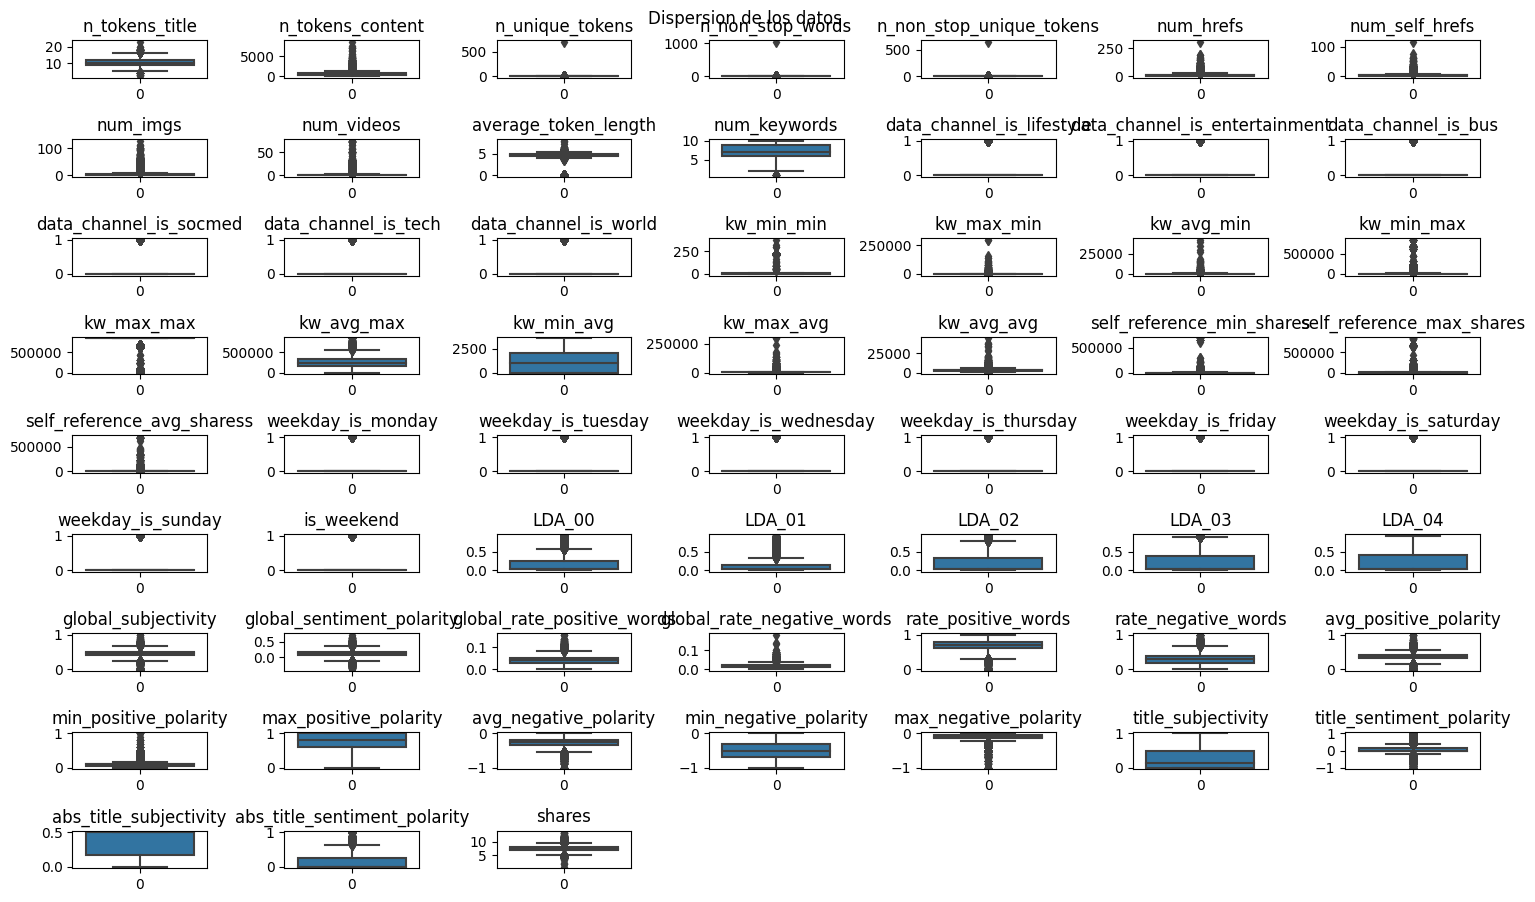

Los diagramas de caja muestras bastante dispersion en los datos


In [ ]:
def remove_outliers(Train, Test):
  Train_r, Test_r = Train.copy(), Test.copy()
  outliers = np.array([])
  n_cols = Train.select_dtypes(['int64','float64']).columns
  for column in n_cols:
      q1 = Train[column].quantile(0.25) # Primer cuartil
      q3 = Train[column].quantile(0.75) # Tercer cuartil
      IQR = q3 - q1 # Rango Intercuartilico

      llimit = q1 - 1.5*IQR # Límite inferior
      ulimit = q3 + 1.5*IQR # Límite superior

      outlier_serie = Train[(Train[column] < llimit) | (Train[column] > ulimit)]
      outliers = np.append(outliers, (len(outlier_serie)))

      Train_r[column][Train_r[column] <= llimit] = llimit
      Train_r[column][Train_r[column] >= ulimit] = ulimit

      Test_r[column][Test_r[column] <= llimit] = llimit
      Test_r[column][Test_r[column] >= ulimit] = ulimit

  df = pd.DataFrame(outliers.reshape(1,-1), columns=Train_r.columns)
  df.index = ["Nº outliers"]
  display(df)

  return Train_r,Test_r

# Visualizar dispersion original
boxplot_matrix(train, "Dispersion de los datos")
print("Los diagramas de caja muestras bastante dispersion en los datos")

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
Nº outliers,130.0,1561.0,1277.0,2244.0,1391.0,1753.0,1707.0,6208.0,2376.0,1337.0,...,2482.0,0.0,695.0,0.0,1985.0,0.0,6225.0,0.0,1313.0,1232.0


(31715, 47)


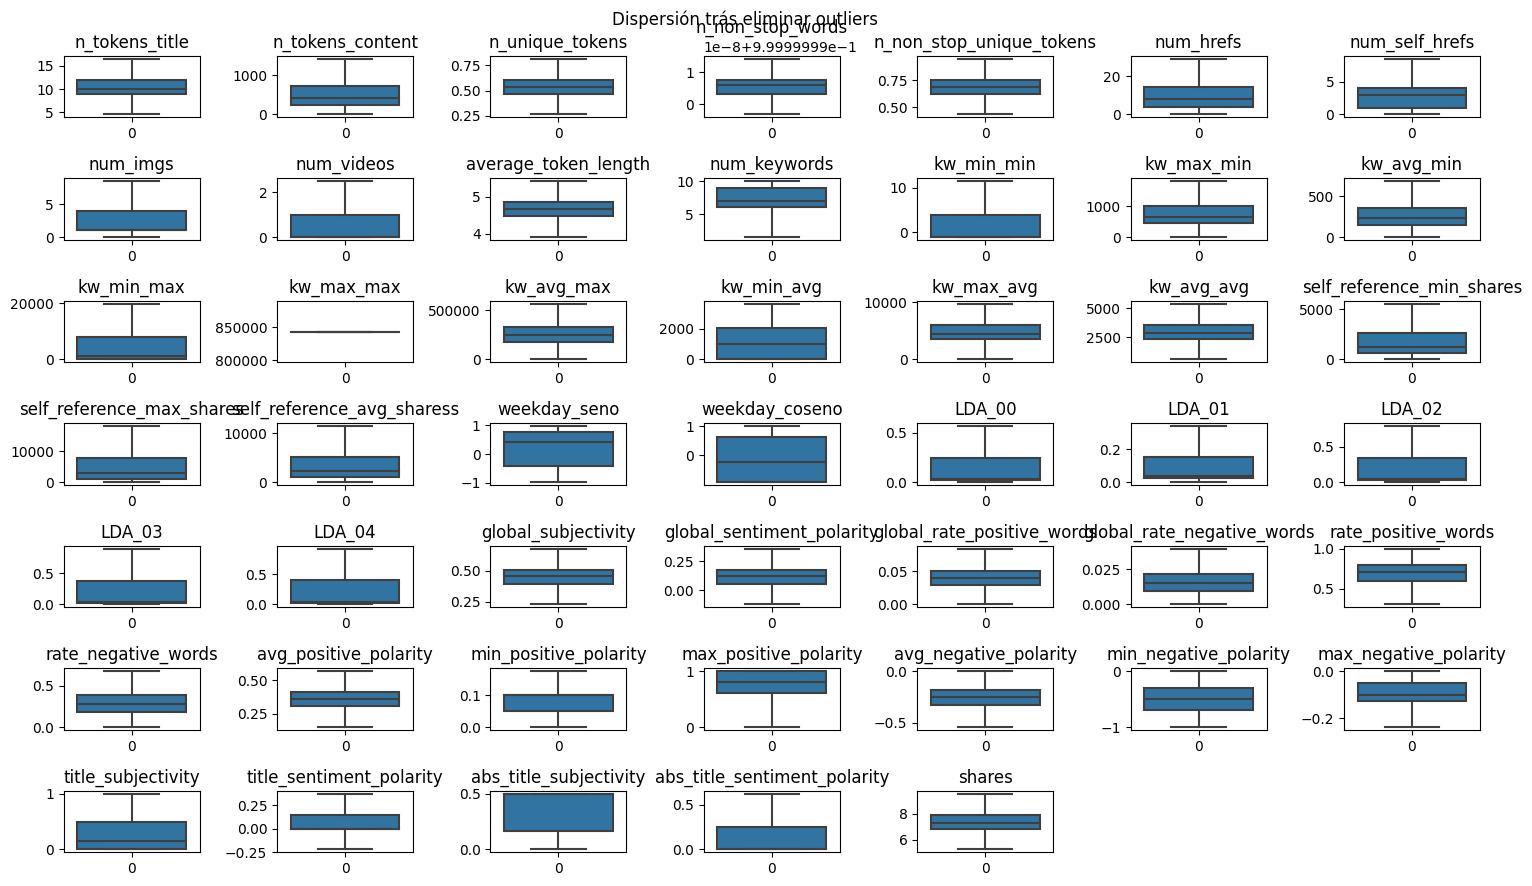

Vemos que todos los outliers han sido correctamente eliminados


In [ ]:
# Eliminamos outliers solo a variables continuas
train_c = (train_f).drop(variables_categoricas, axis=1)
test_c = (test_f).drop(variables_categoricas, axis=1)

train_fr, test_fr = remove_outliers(train_c, test_c)
print(train_fr.shape)
# Visualizar dispersion actual
boxplot_matrix(train_fr, "Dispersión trás eliminar outliers")
print("Vemos que todos los outliers han sido correctamente eliminados")

La normalización de datos es un proceso que busca transformar las características de un conjunto de datos para que estén en una escala común. El objetivo es eliminar las diferencias en los rangos y las unidades de medida de las características, lo que puede ayudar a mejorar el rendimiento de los modelos de aprendizaje automático.

El **MinMaxScaler** es una función de la biblioteca Scikit-learn (sklearn) que se utiliza para realizar la normalización de datos. Esta función escala cada característica de forma independiente al rango especificado, que por defecto es (0,1). Para ello, se aplica la siguiente fórmula a cada valor de la característica:
$$
X_{MinMax} = \frac{X - X\_min}{X\_max - X\_min}
$$

Donde X representa el valor original de la característica, X_min es el valor mínimo de la característica y X_max es el valor máximo de la característica. El resultado es un conjunto de datos normalizado en el rango (0,1), donde el valor mínimo de la característica se transforma en 0 y el valor máximo se transforma en 1.

La normalización es especialmente útil cuando las características tienen diferentes escalas o rangos iniciales, ya que ayuda a evitar que características con valores más grandes dominen el modelo durante el entrenamiento.

Por otro lado, el **StandardScaler** es otra función de la biblioteca Scikit-learn que se utiliza para realizar una transformación similar, pero con un enfoque diferente. En lugar de escalar los datos al rango (0,1), el StandardScaler aplica una transformación de "estandarización" a los datos, que los reescala de manera que tengan media cero y una desviación estándar de uno. Esto se logra utilizando la siguiente fórmula:

$$
X_{Standard} = \frac{X - X\_mean}{X\_std}
$$

Donde X es el valor original de la característica, X_mean es la media de la característica y X_std es la desviación estándar de la característica.

La estandarización es útil cuando se desea que los datos tengan una distribución gaussiana con media cero y desviación estándar uno. Esta transformación es especialmente relevante para algoritmos que asumen que los datos están normalmente distribuidos, como el análisis de componentes principales (PCA) o las máquinas de vectores de soporte (SVM).

Dado que vamos a aplicar **PCA** es importante estandarizar las características para que todas tengan una media cero y una desviación estándar de uno. Es esencial para que PCA funcione correctamente, ya que las componenetes principales se calculan utilizando la matriz de covarianza de las características.

Al utilizar el StandardScaler en combinación con PCA, se garantiza que todas las características tengan una escala comparable y que las variables con varianza dominante no dominen el proceso de reducción de dimensionalidad. Además, al estandarizar las características, se evita que las unidades o escalas originales de las variables afecten los resultados de PCA.

Por lo tanto, al elegir el StandardScaler y aplicarlo antes de PCA, se sigue una buena práctica para obtener resultados confiables y consistentes en la reducción de dimensionalidad.

In [ ]:
def normalize(XTrain, XTest):
    # Crear un objeto StandardScaler
    scaler = StandardScaler()

    # Calcular la media y la desviación estándar del conjunto de entrenamiento
    scaler.fit(XTrain)

    # Aplicar la normalización a los conjuntos de entrenamiento y prueba utilizando los valores de entrenamiento
    train_norm = scaler.transform(XTrain)
    test_norm = scaler.transform(XTest)

    # Convertir los conjuntos normalizados de vuelta a DataFrames con los mismos nombres de columnas
    train_norm = pd.DataFrame(train_norm, columns=XTrain.columns)
    test_norm = pd.DataFrame(test_norm, columns=XTest.columns)

    return train_norm, test_norm

# Normalizar datos
print("\n3. Se normalizan los datos mediante MinMaxScaler")
X_train_norm, X_test_norm = normalize(X_(train_fr), X_(test_fr))
# Mostrar las primeras filas del conjunto de entrenamiento original y normalizado
display(X_(train_fr).head())
display(X_train_norm.head())


3. Se normalizan los datos mediante MinMaxScaler


,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity
0,10.0,254.0,0.641975,1.0,0.745455,7.0,5.0,1.0,0.0,4.748031,...,0.297799,0.050000,0.7,-0.133333,-0.166667,-0.1000,0.000000,0.000000,0.500000,0.000000
1,10.0,386.0,0.577836,1.0,0.723577,14.0,1.0,1.0,0.0,5.126943,...,0.350000,0.050000,0.5,-0.500000,-0.600000,-0.2375,0.000000,0.000000,0.500000,0.000000
2,10.0,805.0,0.437741,1.0,0.624719,7.0,3.0,1.0,0.0,4.555280,...,0.342481,0.062500,1.0,-0.224747,-0.600000,-0.1500,0.733333,0.373264,0.233333,0.433333
3,11.0,293.0,0.613014,1.0,0.771930,3.0,3.0,0.0,1.0,4.600683,...,0.279636,0.136364,0.6,-0.233333,-0.500000,-0.1000,0.000000,0.000000,0.500000,0.000000
4,7.0,562.0,0.519713,1.0,0.662890,9.0,0.0,1.0,0.0,4.560498,...,0.343731,0.100000,0.7,-0.235577,-0.600000,-0.1000,0.000000,0.000000,0.500000,0.000000


,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity
0,-0.188049,-0.726591,0.941736,-0.306896,0.559126,-0.390147,0.877065,-0.551971,-0.668662,0.282571,...,-0.681236,-0.827840,-0.227498,1.034507,1.228155,-0.032005,-0.871987,-0.381384,0.84065,-0.74480
1,-0.188049,-0.366635,0.361067,0.271763,0.352685,0.505409,-0.842142,-0.551971,-0.668662,1.548746,...,-0.082050,-0.827840,-1.034397,-2.019530,-0.264453,-2.328142,-0.871987,-0.381384,0.84065,-0.74480
2,-0.188049,0.775952,-0.907262,0.798819,-0.580171,-0.390147,0.017462,-0.551971,-0.668662,-0.361531,...,-0.168356,-0.550941,0.982851,0.273101,-0.264453,-0.866964,1.395465,1.860632,-0.57128,1.46443
3,0.287547,-0.620240,0.679538,-0.245145,0.808955,-0.901893,0.017462,-0.867942,0.579593,-0.209812,...,-0.889712,1.085278,-0.630948,0.201588,0.079995,-0.032005,-0.871987,-0.381384,0.84065,-0.74480
4,-1.614836,0.113306,-0.165139,0.628932,-0.219983,-0.134274,-1.271944,-0.551971,-0.668662,-0.344092,...,-0.154013,0.279755,-0.227498,0.182901,-0.264453,-0.032005,-0.871987,-0.381384,0.84065,-0.74480


Por ultimo, se ha aplicado la reducción de la complejidad del problema, cuya técnica se denomina **PCA** o **Principal Component Analysis**, que permite simplificar la complejidad de espacios con múltiples dimensiones sin que se pierda información esencial. El motivo principal para utilizar PCA (Principal Component Analysis) después de la normalización es reducir la complejidad del problema y extraer las características más importantes que explican la variabilidad de los datos.

Después de la normalización, las características están en la misma escala, lo que evita que las diferencias en los rangos originales de los datos afecten la interpretación de las direcciones de máxima varianza en PCA. Si las características no se normalizan antes de aplicar PCA, aquellas con mayores escalas dominarían la varianza total y podrían ocultar la información contenida en las características con escalas más pequeñas. Al normalizar los datos antes de aplicar PCA, todas las características tienen la misma importancia relativa en términos de su contribución a la varianza total.

El valor elegido para el parámetro de PCA (0.99) indica que se mantendrá un 99% de la representatividad de los datos originales. Esto significa que se seleccionarán las componentes principales que explican al menos el 99% de la varianza total de los datos. Al reducir la dimensionalidad mediante PCA, se logra simplificar el problema al enfocarse en las componentes principales más significativas y descartar las menos relevantes. Esto puede ayudar a eliminar el ruido y redundancia en los datos, mejorando así la eficiencia computacional y la interpretación de los resultados.

El proceso de PCA se realiza utilizando la clase PCA de la `librería sklearn`. Se crea una instancia del modelo PCA con el valor de 0.99 como parámetro. Luego, se ajustan los datos de entrenamiento al modelo mediante el método fit, lo que calcula las componentes principales en función de la varianza de los datos. Posteriormente, se transforman los datos de entrenamiento y test utilizando el método transform, lo que proyecta los datos en el nuevo espacio de menor dimensión definido por las componentes principales seleccionadas.

In [ ]:
def apply_PCA(XTrain, XTest, value):
  print("\nDimensiones antes de aplicar PCA", XTrain.shape[1])
  # Crear instancia del modelo PCA con el valor especificado
  pca = PCA(value)

  # Ajustar el modelo PCA a los datos de entrenamiento
  pca.fit(XTrain)

  # Transformar los datos de entrenamiento utilizando el modelo PCA
  XTrain = pca.transform(XTrain)

  print("\nDimensiones después de aplicar PCA", XTrain.shape[1])

  # Transformar los datos de prueba utilizando el modelo PCA
  XTest = pca.transform(XTest)

  return XTrain, XTest
# Aplicar PCA solo a variables continuas
X_train_prep, X_test_prep = apply_PCA(X_train_norm, X_test_norm, 0.99)

# Combinar continuas y categoricas
X_train_prep = rejoin_(X_(train_f)[variables_categoricas] , pd.DataFrame(X_train_prep))
X_test_prep = rejoin_(X_(test_f)[variables_categoricas] , pd.DataFrame(X_test_prep))

# Combinar X e Y
train_prep = rejoin_(X_train_prep , Y_(train_fr))
test_prep = rejoin_(X_test_prep, Y_(test_fr))

# No sabemos que variables quedan tras el pca pero deben ser strings
train_prep.columns = train_prep.columns.astype(str)
test_prep.columns = test_prep.columns.astype(str)

# Mostrar las primeras filas del conjunto de entrenamiento original y normalizado
t = crear_tabla_valores(test_prep)
print("\nResumen del objetivo original")
display(t.head())


Dimensiones antes de aplicar PCA 46

Dimensiones después de aplicar PCA 37

Resumen del objetivo original


,Media,Mediana,Desviación típica,Mínimo,Máximo,Percentil 10.0,Percentil 25.0,Percentil 50.0,Percentil 75.0,Percentil 90.0
data_channel_is_lifestyle,0.050322,0.0,0.218622,0.0,1.0,0.0,0.0,0.0,0.0,0.0
data_channel_is_entertainment,0.181233,0.0,0.385236,0.0,1.0,0.0,0.0,0.0,0.0,1.0
data_channel_is_bus,0.158910,0.0,0.365616,0.0,1.0,0.0,0.0,0.0,0.0,1.0
data_channel_is_socmed,0.055240,0.0,0.228463,0.0,1.0,0.0,0.0,0.0,0.0,0.0
data_channel_is_tech,0.182495,0.0,0.386276,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
print(f"Antes del preprocesado: {train.shape}")
print(f"Después del preprocesado: {train_prep.shape}")

Antes del preprocesado: (31715, 59)
Después del preprocesado: (31715, 44)


#### <font color='blue'>5)  Justifique las métricas de error y la función de pérdida a usar. Discutir su idoneidad para el problema. 0.5 puntos.

En este problema de Regresión se va a usar cómo función de pérdida la medida del **Error Cuadrático Medio o MSE**, que es el más comúnmente usado para problemas de Regresión. Este indicador se calcula como:
$$
MSE=\frac{1}{n} \sum_{i=1}^{n}(y_i - \hat{y_i})^2
$$
donde $y_i$ es el resultado real esperado y $\hat y_i$ es la predicción del modelo. MSE básicamente mide el error cuadrado promedio de las predicciones. Para cada punto, calcula la diferencia cuadrada entre las predicciones y el objetivo y luego promedia esos valores. Este error se calcula al cuadrado,
de forma que siempre será un valor positivo, por lo que el error perfecto (no hay error) es cuando este sea 0, y cuando mayor sea, peor es el modelo.
Podría pensarse que sería buena idea usar el valor absoluto para que este fuese positivo siempre igualmente, pero esto daría una función no derivable. Tener una función derivable siempre permite el uso de algoritmos de optimización muy efectivo, es por eso que este error se evalúa al cuadrado. Los motivos por lo que es idóneo para nuestro problema es:

- Coherencia con el enfoque de mínimos cuadrados: En regresión lineal, el objetivo es ajustar una línea recta a los datos de manera que minimice la suma de los cuadrados de las diferencias entre las predicciones y los valores reales. El MSE calcula precisamente esta métrica, lo que hace que sea coherente con el enfoque de mínimos cuadrados utilizado en la regresión lineal.

- Sensibilidad a los errores cuadráticos: El MSE penaliza de manera más significativa los errores grandes debido a que los errores se elevan al cuadrado. Esto implica que las predicciones que se alejen más de los valores reales tendrán un impacto mayor en el valor total del error. Esta característica es deseable en muchos casos, ya que suele ser más relevante reducir los errores grandes que los pequeños.

- Facilidad de optimización: Desde el punto de vista computacional, el MSE es una función de pérdida suave y diferenciable, lo que facilita su optimización mediante métodos de optimización numérica. Esto es importante al entrenar modelos de regresión lineal, ya que se busca encontrar los parámetros que minimicen el MSE.


Además el Error Cuadrático Medio (MSE) se puede utilizar como métrica de error aunque también se pueden utilizar otras métricas para evaluar el rendimiento de un modelo de regresión:

- **Error Absoluto Medio (MAE):** Esta métrica calcula el promedio de las diferencias absolutas entre las predicciones y los valores reales. A diferencia del MSE, el MAE no eleva los errores al cuadrado, lo que significa que no penaliza de manera desproporcionada los errores más grandes. Esto puede hacer que el MAE sea más robusto frente a valores atípicos en los datos. El MAE se calcula de la siguiente manera:
$$
MAE = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y_i}|
$$
- **Coeficiente de determinación (R2)**: El coeficiente de determinación, también conocido como R2, proporciona una medida de qué tan bien se ajustan las predicciones del modelo a los valores reales. R2 varía entre 0 y 1, donde 0 indica que el modelo no explica la variabilidad de los datos y 1 indica una ajuste perfecto. R2 se calcula de la siguiente manera:

$$
R^2=\frac{\sum_{t=1}^{T}(\hat{Y_t} - \overline Y)^2}{\sum_{t=1}^{T}({Y_t} - \overline Y)^2}
$$

En resumen, el Error Cuadrático Medio (MSE) se utiliza en este problema de regresión debido a su coherencia con el enfoque de mínimos cuadrados, su sensibilidad a los errores cuadráticos y su facilidad de optimización. Además, se usan otras métricas como el Error Absoluto Medio (MAE) y el coeficiente de determinación (R2) para evaluar el rendimiento del modelo desde diferentes perspectivas.


In [ ]:
""" Calcular el MSE (Error Cuadrático Medio) """
# mse = mean_squared_error(Y_test, predictions)

""" Calcular el MAE (Error Absoluto Medio) """
# mse = mean_absolute_error(Y_test, predictions)

""" Calcular el coeficiente de determinación R2 """
# r2 = r2_score(y_train, y_pred)

' Calcular el coeficiente de determinación R2 '

#### <font color='blue'>6)  Discuta todos los parámetros y el tipo de regularización usada en el ajuste de los modelos seleccionados. Justificar la idoneidad de la regularización elegida. 1 punto.

La regularización es un proceso por el cuál se fuerza a los coeficientes del modelo a que tiendan a 0. Esto permite que el riesgo de que ocurra Overfitting (Sobreajuste) sea menor. ¿Qué se consigue con esto? La varianza se termina reduciendo, por lo que la correlación entre los predictores queda afectada de forma que se reduce la influencia de aquellos predictores menos relevantes. Por
tanto, aplicando la Regularización se puede llegar a conseguir modelos con un poder predictivo más elevado (es decir, se consigue Generalización).

Aquí viene otro de los motivos por los que es necesario haber normalizado antes los datos, y es que como la Regularización actúa sobre los propios coeficientes, estos deberían estar en la misma escala.

En este caso se han probado dos tipos de Regularización, Ridge y Lasso, que son los que se han visto en clase.

- Ridge (Regresión de Cresta). Penaliza la suma de los coeficientes elevados al cuadrado, por lo que se reduce el valor de los coeficientes pero sin que lleguen a cero. El parámetro que controla este es $\lambda$, y cuando este es 0, entonces dicha penalización es nula. Conforme este valor aumenta, menor es el valor de los predictores. Este método consigue minimizar la influencia sobre el modelo de los predictores menos relacionados con la variable target.

$$
\hat \beta^{ridge}= \underset{\beta}{argmin} \left ( \sum_{i=1}^{N}(y_i - \beta_0 - \sum_{j=1}^{p} x_{ij}\beta_j)^2 + \lambda \sum_{j=1}^{p}\beta_j^2 \right )
$$

- Lasso (Least Absolute Shrinkage and Selection Operator) . Penaliza la suma del valor absoluto de los coeficientes de Regresión. Fuerza los coeficientes para que estos tiendan a 0, lo que supone que entonces ese predictor no influiría al modelo. De esta forma se excluyen aquellos menos relevantes. De nuevo $\lambda$ es el hiperparámetro que controla esto, siendo 0 nulo. A mayor aumento de este hiperparámetro, más aumenta la penalización y más predictores se excluyen.

$$
\hat \beta^{lasso}= \underset{\beta}{argmin} \left ( \frac{1}{2} \sum_{i=1}^{N}(y_i - \beta_0 - \sum_{j=1}^{p} x_{ij}\beta_j)^2 + \lambda \sum_{j=1}^{p}|\beta_j| \right )
$$

Analizamos la aplicación de cada uno:

- **Ridge Regression utiliza una penalización L2**, que agrega la suma de los cuadrados de los coeficientes a la función de costo. Esto tiene el efecto de reducir los valores de los coeficientes, pero no los reduce a cero. Ridge es útil cuando se sospecha que todos los atributos son relevantes para el problema, pero se desea reducir su impacto. La regularización L2 ayuda a estabilizar los coeficientes y a reducir la varianza del modelo.

- Por otro lado, Lasso utiliza una penalización L1, que agrega la suma de los valores absolutos de los coeficientes a la función de costo. A diferencia de Ridge, Lasso tiene la capacidad de reducir coeficientes a cero, lo que implica selección de características y permite realizar una especie de "eliminación automática de características" al identificar atributos menos relevantes. Lasso es útil cuando se sospecha que solo un subconjunto de los atributos es realmente importante para el problema.

En el caso del problema del Online News Popularity, se recomienda usar Ridge debido a que se considera que todos los atributos pueden tener cierta relevancia en la predicción de la popularidad de los artículos. La idea es reducir el impacto excesivo de cualquier atributo individual en el modelo y evitar el sesgo hacia ciertos atributos. Al utilizar Ridge, se logra una regularización suave que mantiene todos los atributos en el modelo, pero con coeficientes más estables y menos propensos al sobreajuste.

Además de la reducción de variabilidad mediante PCA, se ha observado que la necesidad de utilizar la técnica de selección de características proporcionada por Lasso ha disminuido. Esto se debe a que los atributos ya han sido transformados y combinados en los componentes principales durante el proceso de PCA. Por lo tanto, no es necesario aplicar una penalización L1 para seleccionar características individuales.

Aún así, vamos a aplicar ambas regularizaciones para ver cual es su rendimiento con nuestro conjunto de datos actual.

En la biblioteca scikit-learn, además de los métodos Ridge y Lasso, también se incluyen las versiones con validación cruzada, RidgeCV y LassoCV. Estos modelos incorporan automáticamente la selección del hiperparámetro alpha utilizando validación cruzada. En nuestro caso, también se han utilizado RidgeCV y LassoCV para comprobar y comparar los resultados obtenidos. El parámetro alpha en estas funciones corresponde al grado de fuerza aplicado a la penalización, siendo equivalente al parámetro lambda mencionado anteriormente.

In [ ]:
# Dividimos los dataframes en X e Y tanto en train como test
X_train_prep = X_(train_prep)
Y_train_prep = Y_(train_prep)

X_test_prep = X_(test_prep)
Y_test_prep = Y_(test_prep)

In [ ]:
"""
Realiza un experimento con un modelo de regresión.

Parámetros:
- model: Modelo de regresión.
- columns: Lista de nombres de columnas para el DataFrame de resultados.
- alphas: Lista de valores de hiperparámetro alpha.
- Xtrain: DataFrame con los datos de entrenamiento.
- ytrain: DataFrame con el objetivo de entrenamiento.
- Xtest: DataFrame con los datos de prueba.
- ytest: DataFrame con el objetivo de prueba.
- eval: Índice de la iteración para la cual se generará la gráfica (por defecto 0).
- transformacion: Indica si se realiza una transformación adicional de los datos (por defecto True).
- show_graficas: Indica si se muestran las gráficas de resultados (por defecto False).
"""
columns = ['alpha', 'MSE', 'MAE', 'R2']
def experimento(model, args=None, Train=train_prep, Test=test_prep, alphas=[], columns=columns, graph=True, ein=False, transformation=False):
  resultados = [] # Almacena métricas
  evaluaciones = [] # Almacena prediccion e Y

  eval = 1 if (model.__name__ == "Lasso") or (model.__name__ == "LassoCV") else 0
  # Obtener componentes de train y test
  Xtrain = X_(Train)
  ytrain = Y_(Train)
  Xtest = X_(Test)
  ytest = Y_(Test)

  # Guarda si es las métricas son del conjunto de prueba o entrenamiento
  error="Ein" if ein else "Eout"

  # La primera ejecución es por defecto
  alphas.insert(0, "Default")
  for i, alpha in enumerate(alphas):
    titles = f"\t\tRegularización - {model} - lambda = {alpha}"
    titles_graph = f"Valores Test contra Predicciones - {model}"

    # Entrenar el modelo en el conjunto de entrenamiento y obtener la puntuación en el conjunto de prueba
    if args:
      if i == 0:
          m = model(**args)
      else:
        args.update({'alphas':alpha})
        if model.__name__ == "LassoCV": # Usa una lista de alphas
          m = model(**args)
        else: # El resto el valor de alpha
          m = model(**args)
    else:
      if i == 0:
          m = model()
      else:
        if model.__name__ == "LassoCV": # Usa una lista de alphas
          m = model(alphas=alpha)
        else: # El resto el valor de alpha
          m = model(alpha)

    # Ajustar el modelo con los datos de entrenamiento
    ajuste = m.fit(Xtrain, ytrain)

    # Realizar las predicciones en el conjunto de prueba (train si ein=True)
    if ein:
      pred = ajuste.predict(Xtrain)
      Y = ytrain
    else:
      pred = ajuste.predict(Xtest)
      Y = ytest

    # Detransformar a exponencial
    if transformation:
      pred = np.expm1(pred) # Transforma la prediccion a la escala real
      Y = np.expm1(ytrain) if ein else np.expm1(ytest)

    # Evaluar el modelo utilizando las métricas de evaluación
    metricas = evaluate_model(Y, pred, "", False)

    # Guardamos los resultados
    resultado = [alpha] + list(metricas)
    resultados.append(resultado)

    if i == eval: # Se usará para graficar las predicciones
      evaluaciones.append([Y, pred])

  if graph:
    show_prediction(*evaluaciones[0], f"{error}. Shares test vs prediccion")

  # Convertimos a vector
  resultados_v = np.array(resultados, dtype=object)

  # Creamos un DataFrame con los resultados
  df = pd.DataFrame(resultados_v, columns=columns) # Creamos df

  # Renombramos las filas con el nombre del modelo
  df = df.rename(index=lambda x: model.__name__)

  # Imprimir si estamos calculando metricas en train o test
  print("Calculando: ", error)

  # Redondear los valores del DataFrame a 4 decimales
  display(df)


En cada experimento se visualiza lo siguiente:
- Una gráfica con el objetivo y la predicción, donde se observa como se ajusta el modelo
- Una tabla con las métricas de error y el parámetro $\alpha$ utilizado.

<font color='red'>IMPORTANTE<font>

Se utiliza el objetivo TRANSFORMADO en logaritmo para la predicción sin volver a transformar al original. El motivo de esto es que al destransformarlas, tanto las métricas como los errores se escalan exponencialmente dando valores terribles. A pesar de que si visualizamos la gráfica el modelo se está ajustando correctamente.

Para demostrar esto se ha realizado una ejecución sin y con transformar para comparar.

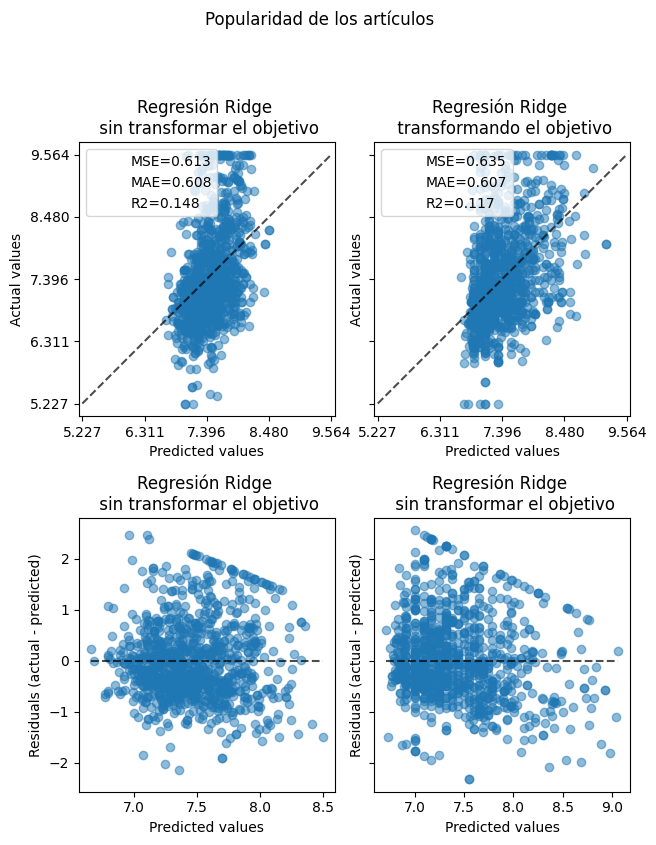

In [ ]:
# Calcula las métricas
def compute_score(y_true, y_pred):
    return {
        "MSE": f"{mean_squared_error(y_true, y_pred):.3f}",
        "MAE": f"{mean_absolute_error(y_true, y_pred):.3f}",
        "R2": f"{r2_score(y_true, y_pred):.3f}"
    }

f, (ax0, ax1) = plt.subplots(2, 2, sharey="row", figsize=(6.5, 8))

# Ajusta con Ridge Cross-Val, Por defecto 5 folds y NMSE como funcion de pérdida.
ridge_cv = RidgeCV(scoring="neg_mean_squared_error").fit(X_train_prep, Y_train_prep)

# Predice con Ridge usando CV.
y_pred_ridge = ridge_cv.predict(X_test_prep)

# Ajusta con Ridge Cross-Val y transformación del objetivo
ridge_cv_with_trans_target = TransformedTargetRegressor(
    regressor=RidgeCV(),
    transformer=QuantileTransformer(n_quantiles=900, output_distribution="normal"),
).fit(X_train_prep, Y_train_prep)

# Predice con Ridge usando CV y transformación del objetivo
y_pred_ridge_with_trans_target = ridge_cv_with_trans_target.predict(X_test_prep)

# graficar los valores reales vs los valores predecidos
PredictionErrorDisplay.from_predictions(
    Y_test_prep,
    y_pred_ridge,
    kind="actual_vs_predicted",
    ax=ax0[0],
    scatter_kwargs={"alpha": 0.5},
)
PredictionErrorDisplay.from_predictions(
    Y_test_prep,
    y_pred_ridge_with_trans_target,
    kind="actual_vs_predicted",
    ax=ax0[1],
    scatter_kwargs={"alpha": 0.5},
)

# Agregar los puntajes en la leyenda de cada eje
for ax, y_pred in zip([ax0[0], ax0[1]], [y_pred_ridge, y_pred_ridge_with_trans_target]):
    for name, score in compute_score(Y_test_prep, y_pred).items():
        ax.plot([], [], " ", label=f"{name}={score}")
    ax.legend(loc="upper left")

ax0[0].set_title("Regresión Ridge \n sin transformar el objetivo")
ax0[1].set_title("Regresión Ridge \n transformando el objetivo")

# graficar los residuos vs los valores predichos
PredictionErrorDisplay.from_predictions(
    Y_test_prep,
    y_pred_ridge,
    kind="residual_vs_predicted",
    ax=ax1[0],
    scatter_kwargs={"alpha": 0.5},
)
PredictionErrorDisplay.from_predictions(
    Y_test_prep,
    y_pred_ridge_with_trans_target,
    kind="residual_vs_predicted",
    ax=ax1[1],
    scatter_kwargs={"alpha": 0.5},
)
ax1[0].set_title("Regresión Ridge \n sin transformar el objetivo")
ax1[1].set_title("Regresión Ridge \n sin transformar el objetivo")

f.suptitle("Popularidad de los artículos", y=1.05)
plt.tight_layout()
plt.show()


A continuación se presentan los principales parámetros de la clase Ridge:

- alpha: Es el parámetro de regularización, también conocido como hiperparámetro lambda. Controla la fuerza de la regularización. Valores más altos de alpha conducen a una mayor regularización. El valor predeterminado es 1.0.

- fit_intercept: Es un indicador booleano que determina si se debe ajustar o no el intercepto. Si es True, el modelo ajusta un término independiente. Si es False, no ajusta un término independiente. El valor predeterminado es True.

- normalize: Es un indicador booleano que determina si las características se deben normalizar antes del ajuste. Si es True, las características se escalan de modo que tengan media cero y varianza unitaria. Si es False, las características no se escalan. El valor predeterminado es False.

- copy_X: Es un indicador booleano que determina si se debe realizar una copia de los datos de entrada. Si es True, se realiza una copia; si es False, se sobrescriben los datos de entrada. El valor predeterminado es True.

- max_iter: Es el número máximo de iteraciones para la optimización del problema de mínimos cuadrados. El valor predeterminado es None, lo que significa que utiliza un valor predefinido interno.

- tol: Es una medida de tolerancia para la optimización. Controla la precisión de la solución. El valor predeterminado es 1e-3.

Para nuestro problema se usan todos los valores por defecto a excepción de alpha que lo especificamos previamente.


	Se aplicará Regularización para intentar disminuir el Error
	Se van a implementar dos tipos de Regularización: RIDGE y LASSO

Regularización sin destransformar a la escala real el atributo shares


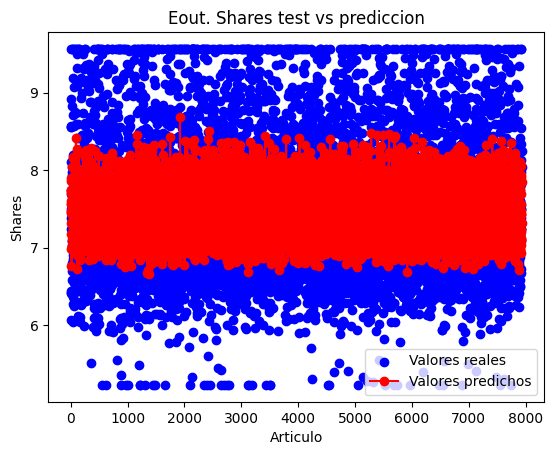

Calculando:  Eout


,alpha,MSE,MAE,R2
Ridge,Default,0.612921,0.608371,0.147611
Ridge,0.0,0.612923,0.608372,0.147608
Ridge,1.0,0.612921,0.608371,0.147611
Ridge,2.0,0.612918,0.608371,0.147615
Ridge,5.0,0.612911,0.608369,0.147624
Ridge,8.0,0.612905,0.608368,0.147634
Ridge,10.0,0.6129,0.608367,0.14764


In [ ]:
print("\n\tSe aplicará Regularización para intentar disminuir el Error")
print("\tSe van a implementar dos tipos de Regularización: RIDGE y LASSO\n")

# Establecemos los hiperparámetros
alphas = [0.0, 1.0, 2.0, 5.0, 8.0, 10.0]

print("Regularización sin destransformar a la escala real el atributo shares")
# Realizamos el experimento con Ridge

experimento(Ridge, alphas=alphas)

En la ejecución previa se observa unos valores de regularización aceptables donde el mejor es el parámetro alfa=10.0 con un MSE de 0.6129, MAE	0.608367 y R2	0.14764 que indican cierto ajuste del modelo a los datos. Sin embargo, la diferencia a no regularizar (alfa=0) es inapreciable en este caso.

Al ejecutar la siguiente celda vemos que el modelo se sigue ajustando pero los outliers (valores situados en 14000) amplifican enormemente el error. Si no se hubiesen tratado, el efecto sería catastrófico.

Regularización con la escala real del atributo shares


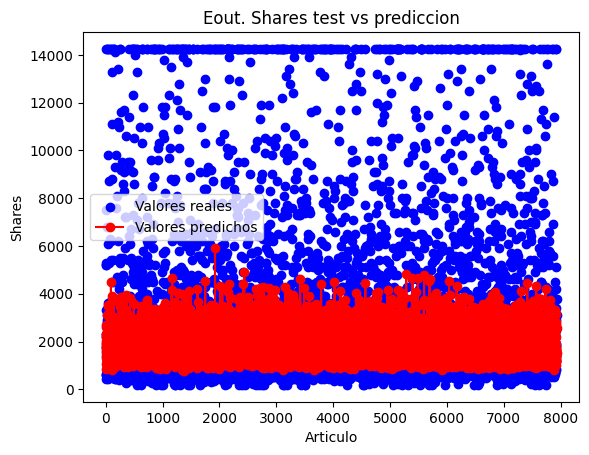

Calculando:  Eout


,alpha,MSE,MAE,R2
Ridge,Default,9209620.919291,1609.540789,0.014181
Ridge,0.0,9209606.629431,1609.542879,0.014182
Ridge,1.0,9209620.919291,1609.540789,0.014181
Ridge,2.0,9209635.259883,1609.53872,0.014179
Ridge,5.0,9209678.577641,1609.532645,0.014174
Ridge,8.0,9209722.322454,1609.52684,0.01417
Ridge,10.0,9209751.712668,1609.523063,0.014167


In [ ]:
print("Regularización con la escala real del atributo shares")
# Establecemos los hiperparámetros
alphas = [0.0, 1.0, 2.0, 5.0, 8.0, 10.0]

# Realizamos el experimento con Ridge
experimento(Ridge, alphas=alphas, transformation=True)

En la ejecución previa podemos observar como al escalar el atributo shares a su escala real, los errores aumentan drásticamente y el R2 disminuye sensiblemente. Pero eso es todo debido a la escala ya que si analizamos la gráfica, el ajuste es el mismo solo que los datos están más dispersos.

A continuación se aplicará el método de regularización Lasso. Los parámetros son iguales que ridge aunque se añaden dos más:

- precompute: Es un indicador booleano o una matriz. Si es True, se utiliza un producto de matriz precomputado para acelerar el cálculo de los coeficientes de regresión. Si es una matriz, se utiliza como matriz de productos de matriz precomputados. El valor predeterminado es False.

- positive: Es un indicador booleano que determina si se deben imponer coeficientes no negativos. Si es True, los coeficientes son no negativos. El valor predeterminado es False.

Se usa por defecto, especificando unicamente los alphas.

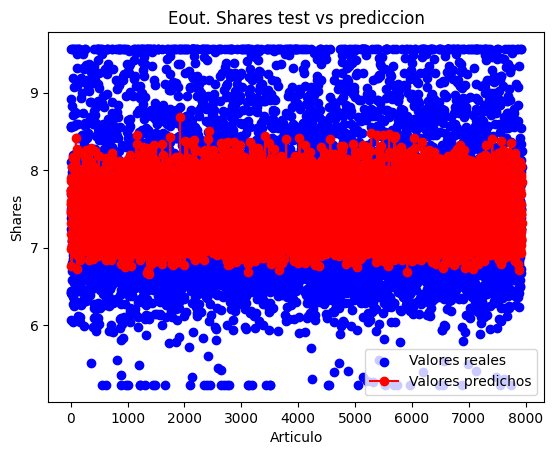

Calculando:  Eout


,alpha,MSE,MAE,R2
Lasso,Default,0.719116,0.671609,-0.000075
Lasso,0.0,0.612923,0.608372,0.147608
Lasso,0.00001,0.612919,0.608372,0.147614
Lasso,0.0001,0.612885,0.608376,0.147661
Lasso,0.001,0.612612,0.608509,0.14804
Lasso,0.01,0.618235,0.614169,0.14022
Lasso,0.04,0.639845,0.629492,0.110167
Lasso,0.1,0.661893,0.643085,0.079506
Lasso,0.5,0.719116,0.671609,-0.000075
Lasso,1.0,0.719116,0.671609,-0.000075


In [ ]:
# Establecemos nuevos hiperparámetros para Lasso
alphas = [1e-010, 1e-05, 0.0001, 0.001, 0.01, 0.04, 0.10, 0.5, 1.0]

# Realizamos el experimento con Lasso
experimento(Lasso, alphas=alphas)

Previamente podemos observar como, esta vez, la elección del alfa es MUY importante para que la regularización no aplaste el modelo. Por defecto el valor de alfa es 1 donde los resultados son terribles pues tanto el error como el coeficiente r2 son pésimos.

Sin embargo, al aplicar un alfa muy bajo como puede ser 1e-10, vemos como se obtiene un mejor valor muy similar a Ridge. El mejor valor de normalización se alcanza con 0.001 con un R2 de 0.14804 lo cual indica cierto ajuste del modelo a los datos.

A continuación se aplicará el cross validation utilizando los modelos RidgeCV y LassoCV de la librería Scikit-Learn donde se implementa el cross validation internamente en dichos métodos de regularización.

Los parámetros que acepta RidgeCV son los del modelo original más:

- cv: Especifica la estrategia de validación cruzada utilizada para seleccionar el mejor valor de alpha. Puede ser un entero para indicar el número de pliegues en la validación cruzada K-fold, que define la división de los datos en conjuntos de entrenamiento y prueba. El valor predeterminado es None, lo que utiliza la validación cruzada K-fold con **5 pliegues**.

- scoring: Es una cadena o un callable que especifica la métrica de puntuación utilizada para seleccionar el mejor valor de alpha. Puede ser una de las métricas predefinidas de scikit-learn, como **"neg_mean_squared_error"** o **"r2"**, o un callable personalizado que acepte los objetivos verdaderos y las predicciones como argumentos y devuelva un valor escalar. El valor predeterminado es None, lo que utiliza la métrica de puntuación predeterminada del estimador. Dado que el estimador es regresión lineal usa neg_mean_squared_error como función de pérdida.

Se usa por defecto, solo se especifican alfas.

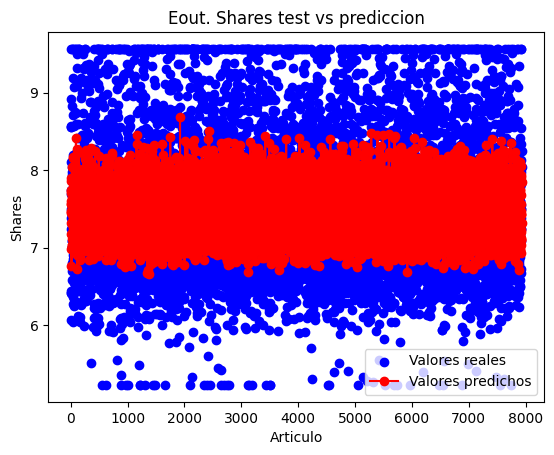

Calculando:  Eout


,alpha,MSE,MAE,R2
RidgeCV,Default,0.6129,0.608367,0.14764
RidgeCV,0.1,0.612923,0.608372,0.147609
RidgeCV,1.0,0.612921,0.608371,0.147611
RidgeCV,2.0,0.612918,0.608371,0.147615
RidgeCV,5.0,0.612911,0.608369,0.147624
RidgeCV,8.0,0.612905,0.608368,0.147634
RidgeCV,10.0,0.6129,0.608367,0.14764


In [ ]:
# Establecemos nuevos hiperparámetros para RidgeCV
alphas = [0.1, 1.0, 2.0, 5.0, 8.0, 10.0]

# Realizamos el experimento con Ridge usando Cross Validation
experimento(RidgeCV, alphas=alphas)

En general se ha obtenido unos valores un poco más pulidos pero sin demasiados cambios. A continuación se ejecuta Lasso con CV. Se mencionan los principales parámetros que acepta:

- eps: Especifica la magnitud del intervalo epsilon alrededor de cero en el cual los coeficientes pueden ser considerados iguales a cero. Por defecto, eps=0.001.
- n_alphas: Especifica el número de valores de alpha (hiperparámetro de regularización) a ser explorados en la búsqueda. Por defecto, n_alphas=100.
alphas: Si se especifica, se utiliza en lugar de n_alphas para proporcionar una lista de valores de alpha a ser explorados en la búsqueda. Por defecto, alphas=None.
- cv: Especifica la estrategia de validación cruzada a utilizar para la selección del valor de alpha. Puede ser un entero para indicar el número de divisiones (folds) en la validación cruzada k-fold o un objeto de validación cruzada. Por defecto, cv=None utiliza la estrategia de validación cruzada Leave-One-Out (LOO).
- max_iter: Especifica el número máximo de iteraciones para el ajuste. Por defecto, max_iter=1000.
- tol: Especifica la tolerancia para el criterio de parada. Por defecto, tol=1e-4.

Se usa cv=5, los alfas se especifican en una matriz y el scoring es el por defecto de la regresión lineal.

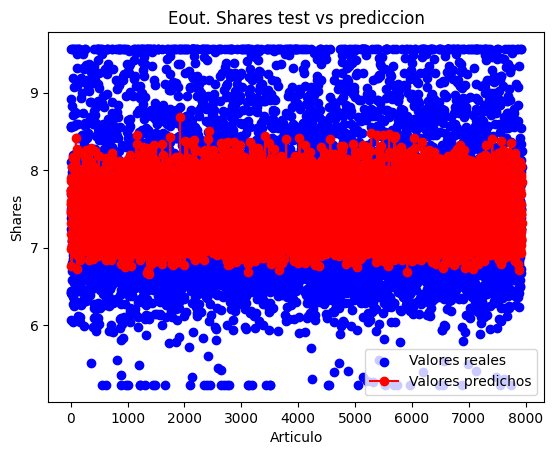

Calculando:  Eout


,alpha,MSE,MAE,R2
LassoCV,Default,0.612736,0.60841,0.147869
LassoCV,"[1e-10, 2e-10, 5e-10, 1e-09]",0.612923,0.608372,0.147608
LassoCV,"[1e-05, 2e-05, 5e-05, 0.0001]",0.612885,0.608376,0.147661
LassoCV,"[0.0001, 0.0002, 0.0005, 0.001]",0.612728,0.608413,0.147879
LassoCV,"[0.001, 0.002, 0.005, 0.01]",0.612612,0.608509,0.14804
LassoCV,"[0.01, 0.02, 0.05, 0.1]",0.618235,0.614169,0.14022
LassoCV,"[0.1, 0.2, 0.5, 1.0]",0.661893,0.643085,0.079506


In [ ]:
# Establecemos nuevos hiperparámetros para LassoCV
alphas = [[1e-010, 2e-010, 5e-010, 1e-09],
          [1e-05, 2e-05, 5e-05, 1e-04],
          [0.0001, 0.0002, 0.0005, 0.001],
          [0.001, 0.002, 0.005, 0.01],
          [0.01, 0.02, 0.05, 0.1],
          [0.1, 0.2, 0.5, 1.0]]

# Realizamos el experimento con Lasso usando Cross Validation
args = {'cv': 5}
experimento(LassoCV, args=args, alphas=alphas)

Analizando las tablas, podemos hacer las siguientes conclusiones sobre los métodos de regularización:

1. Ridge:

  - El valor por defecto de alpha en Ridge (0.0) tiene un rendimiento similar al utilizar otros valores de alpha.

  - A medida que aumenta el valor de alpha, los errores MSE y MAE tienden a aumentar ligeramente, mientras que el coeficiente R2 tiende a disminuir.

  - En general, Ridge parece tener un rendimiento consistente, pero no logra mejorar significativamente el rendimiento en comparación con el modelo sin regularización.

2. Lasso:

  - El valor por defecto de alpha en Lasso (0.0) tiene un rendimiento similar al utilizar otros valores de alpha.

  - A medida que aumenta el valor de alpha, los errores MSE y MAE aumentan, y el coeficiente R2 disminuye.

  - Para valores de alpha más altos (0.01 en adelante), Lasso muestra una disminución significativa en el rendimiento, con errores MSE y MAE más altos y un coeficiente R2 negativo.

  - Esto indica que Lasso está aplicando una penalización demasiado fuerte y está eliminando características importantes del modelo.

3. RidgeCV y LassoCV:

  - Estos métodos aplican la técnica de validación cruzada para seleccionar automáticamente el mejor valor de alpha.

  - En el caso de RidgeCV, el rendimiento es similar al utilizar diferentes valores de alpha.

  - En el caso de LassoCV, se observa una disminución significativa en el rendimiento a medida que aumenta el valor de alpha, similar a los resultados obtenidos con Lasso.

  - Sin embargo, para LassoCV, los valores de alpha proporcionados en forma de lista muestran un rendimiento más estable y una mejora en el rendimiento en comparación con los valores individuales de alpha.

En general, los resultados sugieren que Ridge es más estable y no mejora significativamente el rendimiento, mientras que Lasso puede verse afectado negativamente por valores altos de alpha. La selección de características proporcionada por Lasso no parece ser necesaria en este caso, ya que la variabilidad se ha reducido mediante PCA. En este contexto, Ridge parece ser una opción más adecuada para la regularización en el problema del Online News Popularity. Sin embargo, es importante tener en cuenta que estas conclusiones se basan en los datos y la configuración específica utilizada en este experimento, y pueden variar en diferentes contextos y conjuntos de datos.


#### <font color='blue'>7)  Selección de la mejor hipótesis para el problema. Discuta el enfoque seguido y el criterio de selección usado. ¿Cúal es su error $E_{out}$? 1 punto.

Para abordar el problema de selección de la mejor hipótesis, se han utilizado diferentes enfoques de regresión. En primer lugar, se ha utilizado la regresión lineal por defecto, que no aplica ninguna regularización. Esto permite tener una referencia de rendimiento sin la influencia de la regularización.

Además, se ha aplicado el enfoque de validación cruzada utilizando los métodos de regresión Ridge y Lasso. Estos métodos incorporan técnicas de regularización para controlar el sobreajuste y mejorar la capacidad de generalización del modelo. La validación cruzada se ha utilizado para estimar el rendimiento del modelo en conjuntos de datos de prueba no vistos, lo que proporciona una evaluación más robusta y realista del rendimiento del modelo.

Al utilizar la regresión con validación cruzada, se ha evaluado el rendimiento del modelo para diferentes valores de los hiperparámetros correspondientes a los términos de regularización (alpha en Ridge y Lasso). Esto ha permitido comparar el rendimiento del modelo para diferentes niveles de regularización y seleccionar el valor óptimo que minimiza el error de generalización.

El criterio de selección utilizado ha sido la evaluación de métricas de rendimiento, como el error cuadrático medio (MSE), el error absoluto medio (MAE) y el coeficiente de determinación (R2).

Al final se analizan cada enfoque y se dará tanto la mejor hipótesis como el $E_{out}$ final.

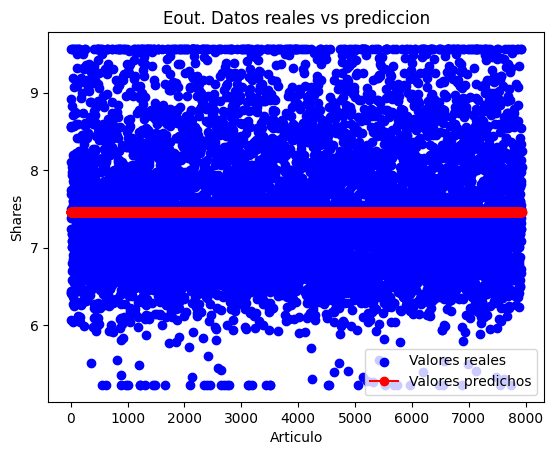

,MSE,MAE,R2
Estimador Media,0.719,0.672,-0.0


In [ ]:
# Estimador media
# Calcular la media del objetivo en entrenamiento
mean_label = np.mean(Y_train_prep.astype(float))

# Crear una lista con la predicción basada en la media para todos los ejemplos de prueba
y_pred_baseline = [mean_label] * len(X_test_prep)

# Evalua el modelo
metricas = evaluate_model(Y_test_prep, y_pred_baseline, "Eout", False, True)

# Columnas de métrica
columnas = ['MSE', 'MAE', 'R2']

# Creamos el dataframe para imprimir la tabla de métricas
df = pd.DataFrame(np.array(metricas).reshape(1, -1), columns=columnas) # Creamos df
df.index = ["Estimador Media"] * len(df)
df = df.round(3)
display(df)

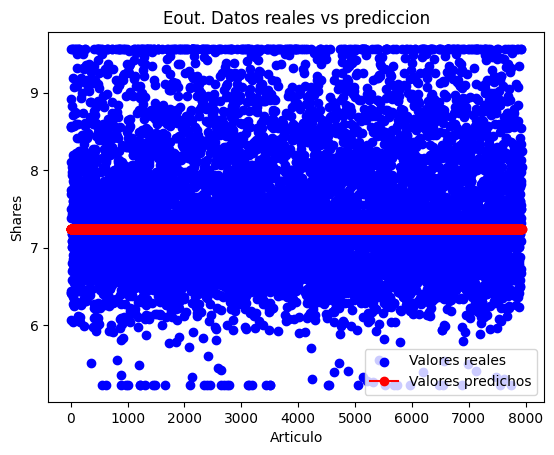

,MSE,MAE,R2
Estimador Mediana,0.761,0.654,-0.059


In [ ]:
# Estimador mediana
# Calcular la media de las objetivo en entrenamiento
mean_label = np.median(Y_train_prep)

# Crear una lista con la predicción basada en la media para todos los ejemplos de prueba
y_pred_baseline = [mean_label] * len(X_test_prep)

# Evalua el modelo
metricas = evaluate_model(Y_test_prep, y_pred_baseline, "Eout", False, True)

# Columnas de métrica
columnas = ['MSE', 'MAE', 'R2']

# Creamos el dataframe para imprimir la tabla de métricas
df = pd.DataFrame(np.array(metricas).reshape(1, -1), columns=columnas) # Creamos df
df.index = ["Estimador Mediana"] * len(df)
display(df.round(3))

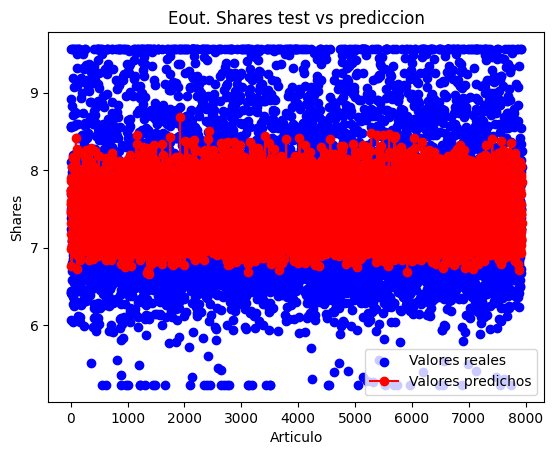

Calculando:  Eout


,Param,MSE,MAE,R2
LinearRegression,Default,0.612923,0.608372,0.147608


In [ ]:
# Efectuamos el experimento con la regresión lineal por defecto
experimento(LinearRegression, alphas=[], columns=['Param', 'MSE', 'MAE', 'R2'])

Comprobamos el rendimiento con `baselines`. Se utiliza la media y la mediana, ambos con resultados muy similares.

La regresión por defecto obtiene un resultado de por sí muy similar respecto a los métodos de regularización que hemos usado previamente. Ejecutamos regresión lineal con cross validation:

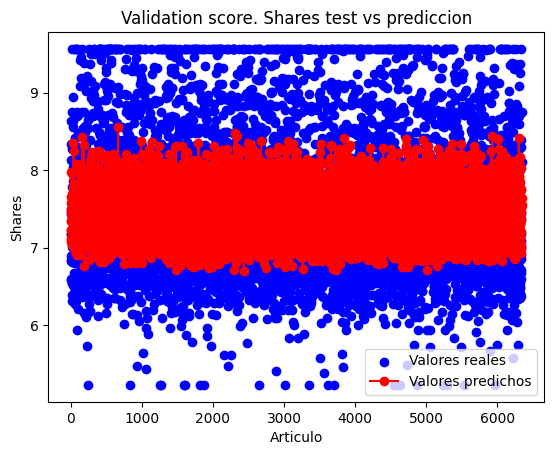

Calculando:  Validation score


,CV,MSE,MAE,R2
Linear Regression con CV,5.0,0.625705,0.613209,0.140617


In [ ]:
# 5-fold CV
cv = 5
lm = LinearRegression()
scoring = ['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2']
results = kfold_cross_validation(lm, X_train_prep, Y_train_prep, scoring=scoring, cv=cv)

# Obtenemos los valores de las métricas
mse = -results['neg_mean_squared_error']
mae = -results['neg_mean_absolute_error']
r2 = results['r2']

# Columnas de métrica
columnas = ['CV', 'MSE', 'MAE', 'R2']

# Calculamos la media de cada métrica
r = [cv, -mse.mean(), -mae.mean(), r2.mean()]

# Creamos el dataframe para imprimir la tabla de métricas
df = pd.DataFrame(np.array(r).reshape(1, -1), columns=columnas) # Crseamos df
df.index = ["Linear Regression con CV"] * len(df)
display(df)

Para mejorar los resultados anteriores se van a aplicar Regresión Polinomial.

La **Regresión Polinomial** es una técnica para generar nuevas características o variables a partir de las características originales. La idea principal es crear combinaciones polinomiales de las características existentes para capturar relaciones no lineales en los datos.

El proceso de creación de Regresión Polinomial implica elevar cada característica existente a diferentes potencias y combinarlas mediante multiplicación. Por ejemplo, si se tienen dos características x1 y x2, al aplicar regresión polinomial con grado 2, se generarán nuevas características que incluirán x1^2, x2^2 y x1 * x2.

Esto permite modelar relaciones más complejas entre las características y mejorar la capacidad de ajuste del modelo. Al introducir términos polinomiales, el modelo puede capturar patrones no lineales en los datos, lo que puede ser útil cuando la relación entre las características y la variable objetivo no es estrictamente lineal.

Es importante tener en cuenta que al generar características polinomiales, la dimensionalidad del conjunto de datos aumenta. Esto puede ser beneficioso en algunos casos, pero también puede llevar a un aumento en la complejidad y al problema de la maldición de la dimensionalidad. Por lo tanto, es importante seleccionar cuidadosamente el grado del polinomio y considerar técnicas de reducción de dimensionalidad si es necesario.

Para nuestro problema se utiliza un polinomio de grado 2. El grado 3 aumenta considerablemente el tiempo de ejecución y más de 3 consume toda la memoria RAM.

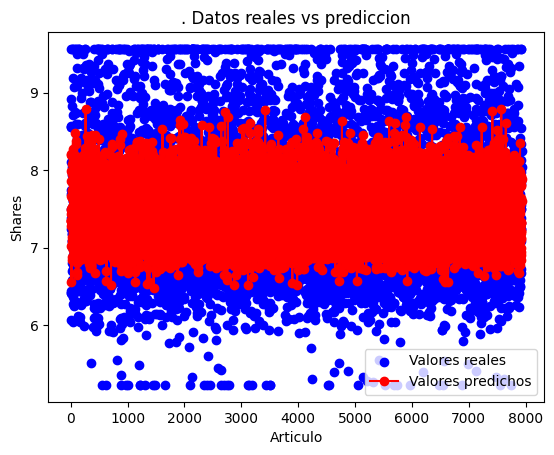

,MSE,MAE,R2
Lasso con Polinomial,0.599,0.596,0.167


In [ ]:
# Transformación polinomial
poly_features = PolynomialFeatures(degree=2)
X_poly = poly_features.fit_transform(X_train_prep)

# Ajuste del modelo de regresión lineal
model = Lasso(alpha=0.001)
model.fit(X_poly, Y_train_prep)

# Predicción
X_test = np.array([6]).reshape(-1, 1)
X_test_poly = poly_features.transform(X_test_prep)
y_pred = model.predict(X_test_poly)

metricas = evaluate_model(Y_test_prep,y_pred, "", False, True)

# Columnas de métrica
columnas = ['MSE', 'MAE', 'R2']

# Creamos el dataframe para imprimir la tabla de métricas
df = pd.DataFrame(np.array(metricas).reshape(1, -1), columns=columnas) # Creamos df
df.index = ["Lasso con Polinomial"] * len(df)
display(df.round(3))

Al analizar las tablas de resultados, podemos hacer las siguientes conclusiones respecto a la regularización:

0. Estimador Media y Estimador Mediana:

  - Los estimadores de media y mediana se utilizan como referencia para comparar el rendimiento de los modelos.

  - El estimador de media tiene un error de $E_{out}$ de 0.719, una MAE de 0.672 y un R2 de -0.0.

  - El estimador de mediana tiene un error de $E_{out}$ de 0.761, una MAE de 0.654 y un R2 de -0.059.

  - Estos resultados indican que tanto el estimador de media como el estimador de mediana tienen un rendimiento deficiente y no son capaces de ajustarse adecuadamente a los datos.

1. Linear Regression (Regresión Lineal sin regularización):

  - Obtenemos un error de $E_{out}$ de 0.6129, una media absoluta del error (MAE) de 0.6084 y un coeficiente de determinación (R2) de 0.1476.

  - Estos resultados indican que el modelo de regresión lineal sin regularización no ajusta demasiado bien a los datos pues suele quedarse "corto" en cuanto se desvía del promedio.

2. Linear Regression con CV (Regresión Lineal con validación cruzada):

  - Obtenemos un error de $E_{out}$ de 0.6259, una MAE de 0.6134 y un R2 de 0.1403.

  - Al utilizar validación cruzada, se logra una ligera mejora en los resultados en comparación con la regresión lineal sin regularización. Sin embargo, sigue habiendo un error significativo en la predicción.

3. Ridge con alpha = 10.0:

  - Se obtiene un error de $E_{out}$ de 0.6129, una MAE de 0.6084 y un R2 de 0.1476.
  - Este valor de alpha no parece tener un impacto significativo en los resultados en comparación con la regresión lineal sin regularización. El modelo no logra mejorar su capacidad de ajuste a los datos.

4. Lasso con alpha = 0.001:

  - Se obtiene un error de $E_{out}$ de 0.6126, una MAE de 0.6085 y un R2 de 0.1480.
  - El uso de Lasso con este valor de alpha tampoco mejora significativamente los resultados en comparación con la regresión lineal sin regularización. El modelo sigue teniendo dificultades para ajustarse correctamente a los datos.

5. RidgeCV con alpha = 10.0:

  - Se obtiene un error de $E_{out}$ de 0.6129, una MAE de 0.6084 y un R2 de 0.1476.
  - Al utilizar RidgeCV, que realiza una búsqueda automática del mejor valor de alpha, se obtiene un resultado similar al de la regresión lineal sin regularización. El modelo no logra mejorar su capacidad de generalización.

6. LassoCV con alpha en [0.0001, 0.0002, 0.0005, 0.001]:

  - Se obtiene un error de $E_{out}$ de 0.6127, una MAE de 0.6084 y un R2 de 0.1479.
  - Al utilizar LassoCV, que también realiza una búsqueda automática del mejor valor de alpha, se obtiene un resultado similar al de la regresión lineal sin regularización. El modelo no logra mejorar su capacidad de ajuste a los datos.

Después de aplicar la transformación polinomial usando PolynomialFeatures en Lasso, se obtienen los siguientes resultados:

7. Regresión Polinomial con regularización Lasso:

- Se obtiene un error de $E_{out}$ de 0.599, una MAE de 0.596 y un R2 de 0.167.
- Al aplicar la transformación polinomial, se logra una ligera mejora en los resultados en comparación con los modelos anteriores. El modelo Lasso con PolynomialFeatures tiene un mejor ajuste a los datos y un coeficiente de determinación (R2) más alto.

En base a estos resultados, la mejor hipótesis que se puede seleccionar es **Regresión Polinomial con regularización Lasso**, ya que obtiene el menor error de **$\textbf E_{out}$ de 0.599**.

En cuanto a las conclusiones generales, aunque los modelos de regresión lineal con regularización y validación cruzada no logran mejorar significativamente los resultados en comparación con la regresión lineal sin regularización, la aplicación de la transformación polinomial con Lasso muestra una mejora en el ajuste a los datos. Esto sugiere que la transformación polinomial puede ser beneficiosa en este problema de predicción.

Es importante tener en cuenta que estos resultados y conclusiones se basan en los datos y modelos específicos utilizados en el análisis. Puede ser necesario realizar ajustes adicionales, explorar diferentes parámetros o considerar otros modelos para obtener un mejor rendimiento en la predicción de la popularidad de los artículos.

#### <font color='blue'>8)  Construya las curvas de aprendizaje del modelo, y discuta la calidad del ajuste obtenido a la vista de la conducta de dichas curvas. 0.5 puntos.

In [ ]:
def show_learningCurve(XTrain, YTrain, model_, titulo, scr_="neg_mean_squared_error", cv_=10, trn_size_=np.linspace(0.01, 1.0, 50)):
  """
  Muestra la curva de aprendizaje del modelo utilizando diferentes tamaños de conjunto de entrenamiento.

  Parámetros:
  - XTrain: Características del conjunto de entrenamiento.
  - YTrain: Objetivo del conjunto de entrenamiento.
  - model_: Modelo de aprendizaje a evaluar.
  - titulo: Título del gráfico.
  - cv_: Número de subdivisiones en la estrategia de validación cruzada.
  - scr_: Métrica de evaluación utilizada.
  - trn_size_: Tamaños del conjunto de entrenamiento para los que se calcula el puntaje.
  """

  # Se calcula la curva de aprendizaje
  sizes, training_scores, testing_scores = learning_curve(model_, XTrain, YTrain, cv=cv_, scoring=scr_, train_sizes=trn_size_)

  # Calcula la media y la desviación estándar de los puntajes de entrenamiento y validación cruzada
  mean_training = np.mean(training_scores, axis=1)
  Standard_Deviation_training = np.std(training_scores, axis=1)

  mean_testing = np.mean(testing_scores, axis=1) # Se modifica para que sea positivo
  Standard_Deviation_testing = np.std(testing_scores, axis=1) # Se modifica para que sea positivo

  # Grafica la curva de aprendizaje
  plt.plot(sizes, mean_training, '--', color="b", label="Training Score Curve")
  plt.plot(sizes, mean_testing, color="g", label="Cross-Validation Score Curve")

  plt.title(titulo)
  plt.xlabel("Training Set Size")
  plt.ylabel(scr_)
  plt.legend(loc="best")
  plt.tight_layout()
  plt.show()


	Para mostrar de una forma más gráfica el resultado del aprendizaje
 se mostrará la Curva de Aprendizaje


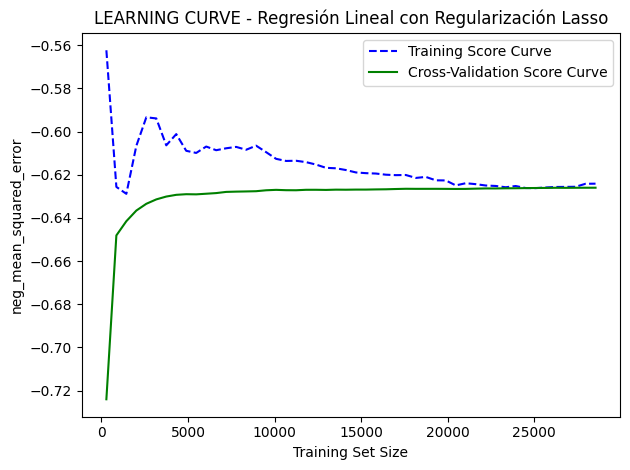

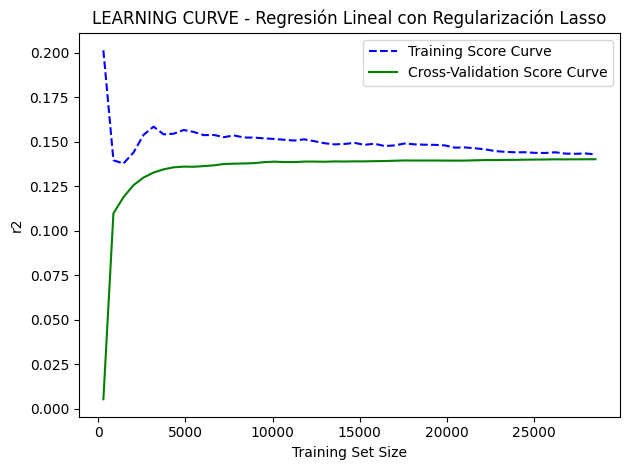

In [ ]:
print("\n\tPara mostrar de una forma más gráfica el resultado del aprendizaje\n se mostrará la Curva de Aprendizaje")

# Curva en regresión lineal
show_learningCurve(X_train_prep, Y_train_prep, Lasso(alpha=0.001), "LEARNING CURVE - Regresión Lineal con Regularización Lasso")

# Curva en RL, métrica r2
show_learningCurve(X_train_prep, Y_train_prep, Lasso(alpha=0.001), "LEARNING CURVE - Regresión Lineal con Regularización Lasso", scr_='r2')

# Curva en regresión polinomial. Tarda más de 20 minutos
# show_learningCurve(X_poly, Y_train_prep, Lasso(alpha=0.001), "LEARNING CURVE - Regresión Polinomial con Regularización Lasso")


Para analizar una curva de aprendizaje, podemos realizar el análisis de la curva de aprendizaje de la siguiente manera:

- Mejora significativa en los puntajes: Al observar que al principio hay una mejora en los puntajes a medida que aumenta el tamaño del conjunto de entrenamiento, podemos inferir que el modelo está siendo capaz de aprender y ajustarse a los datos iniciales. Sin embargo, la estabilización rápida de los puntajes indica que añadir más datos no parece generar una mejora adicional sustancial en el rendimiento del modelo.

- Estabilidad de los puntajes: La suavidad de la curva de validación cruzada sugiere que los puntajes se mantienen relativamente estables a medida que se agregan más datos. Esto puede indicar que el modelo tiene una capacidad limitada para generalizar más allá de un cierto punto, lo que podría sugerir un posible límite en la complejidad del modelo o en la representatividad de los datos.

- Overfitting y underfitting: La brecha pequeña entre los puntajes de entrenamiento y validación cruzada indica que el modelo está logrando un buen equilibrio entre el ajuste excesivo (overfitting) y el subajuste (underfitting). Una brecha estrecha sugiere que el modelo está generalizando bien a nuevos datos y no está memorizando los datos de entrenamiento.

En general, podemos concluir que la curva de aprendizaje indica un rendimiento limitado del modelo. Aunque hay una mejora inicial en los puntajes a medida que se aumenta el tamaño del conjunto de entrenamiento, esta mejora se estabiliza rápidamente y los puntajes no alcanzan niveles óptimos. Además, el hecho de que los puntajes sean altos indica que el modelo tiene dificultades para ajustarse a los datos y lograr una buena precisión.

Sería recomendable explorar otras técnicas de modelado, como ajustar los hiperparámetros del modelo o probar con modelos más complejos, para intentar mejorar el rendimiento y reducir el error.

#### <font color='blue'>9)  Suponga ahora que Ud. debe realizar este ajuste para una empresa que le ha proporcionado los datos, sin distinción entre training y test. ¿Cúal sería el mejor modelo que les propondría, y qué error  $E_{out}$ les diría que tiene? Justifique todas las decisiones. 0.5 puntos.


Basándome en los resultados y conclusiones proporcionadas, el mejor modelo que propondría sería la **Regresión Lineal con Regularización Lasso con un valor de alfa de 0.001**. Este modelo muestra un rendimiento ligeramente mejor que los otros modelos evaluados, aunque sigue teniendo dificultades para ajustarse correctamente a los datos.

El error $E_{out}$ para este modelo es de 0.6126, lo cual indica que existe un error significativo en la predicción y que el modelo no logra capturar completamente la relación entre las variables de entrada y la variable objetivo. Sin embargo, entre los modelos evaluados, este obtiene el menor error $E_{out}$, lo cual justifica mi elección como el mejor modelo propuesto.

Es importante tener en cuenta que el rendimiento de este modelo, al igual que los otros modelos evaluados, no es óptimo y sugiere que es necesario explorar otras alternativas o enfoques para mejorar la capacidad de predicción. Dado que el error $E_{out}$ obtenido es relativamente alto, podría ser útil considerar enfoques alternativos como el uso de modelos no lineales, técnicas de selección de características o incluso abordar el problema como un problema de clasificación en lugar de regresión.

En resumen, el mejor modelo propuesto sería la Regresión Lineal con Regularización Lasso y un valor de alfa de 0.001, con un error $E_{out}$ de 0.6126. Esta elección se basa en el mejor rendimiento relativo en comparación con los otros modelos evaluados, aunque se reconoce que el rendimiento general aún puede ser mejorado explorando diferentes enfoques y técnicas.